In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import tensorflow.contrib.layers as layers

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8) # set default size of plots
plt.rcParams['agg.path.chunksize'] = 10000
%config InlineBackend.figure_format = 'retina'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

sns.set_style("whitegrid")
sns.set_palette("bright")

In [54]:
def model(x, reuse=False):
    """
    2 Hidden Layer (5 x 5) neural network with RELU activation.
    """
    fc1 = layers.fully_connected(x, 20, activation_fn=tf.nn.relu, reuse=reuse)
    fc2 = layers.fully_connected(fc1, 20, activation_fn=tf.nn.relu, reuse=reuse)
    y = layers.fully_connected(fc2, 5, activation_fn=None, reuse=reuse)
    return y

def preprocess(X):
    """
    Scales and shifts X to have 0 mean and unit variance.
    """
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    return X, scaler

def get_data(df, X_vars, y_vars, train_test_split=1.0):
    """
    Gets normalized features and the response variable from the dataframe.
    
    Args:
      - df: Pandas dataframe containing the input data.
      - X_vars: List of column names for the input matrix.
      - y_var: Column name for the output matrix.
      - train_test_split: Percentage of data to go in train.
    
    Returns:
        - X: Normalized input matrix containing X_vars.
        - y: Array containing the response variable.
        - X_scaler: Module used to normalize X.
    """
    # Filter out rows where one of the input variables and/or response variable is NaN.
    df = df[X_vars + y_vars].dropna()
    df = df.reindex(np.random.permutation(df.index))
    df_train = df.iloc[:int(df.shape[0] * train_test_split)]
    df_test = df.iloc[int(df.shape[0] * train_test_split):]
    X_train, X_scaler = preprocess(df_train[X_vars])
    X_test = X_scaler.transform(df_test[X_vars])
    y_train = df_train[y_vars]
    y_test = df_test[y_vars]
    return X_train, y_train, X_test, y_test, X_scaler

In [55]:
df = pd.read_csv("20170213_test-data.csv")
X_vars, y_vars, train_test_split = ['x1', 'x2', 'x3', 'x4', 'x5'], ['y1', 'y2', 'y3', 'y4', 'y5'], 0.8
X_train, y_train, X_val, y_val, X_scaler = get_data(df, X_vars, y_vars, train_test_split)
print "X_train: ", X_train.shape
print "X_val: ", X_val.shape
print "y_train: ", y_train.shape
print "y_val: ", y_val.shape

X_train:  (4000, 5)
X_val:  (1000, 5)
y_train:  (4000, 5)
y_val:  (1000, 5)


In [56]:
X_uniform = np.mgrid[-2:2.01:0.2, -2:2.01:0.2, -2:2.01:0.2, -2:2.01:0.2, -2:2.01:0.2].reshape(5,-1).T
X_gaussian = np.random.multivariate_normal([0, 0, 0, 0, 0], np.diag([1, 1, 1, 1, 1]), 50000)

In [57]:
# Split the data into batches
batch_size = 256
num_batches = X_train.shape[0] / batch_size
X_batches = np.array_split(X_train, num_batches)
# y_batches = np.array_split(y_train.values.reshape(-1, 1), num_batches)
y_batches = np.array_split(y_train, num_batches)

# Placeholders for the 
X = tf.placeholder(tf.float32, shape=[None, X_train.shape[1]])
# y = tf.placeholder(tf.float32, shape=[None, 1])
y = tf.placeholder(tf.float32, shape=[None, 5])
y_pred = model(X, reuse=False)

# Minimize the mean squared errors.
loss = tf.reduce_mean(tf.square(y_pred - y))
optimizer = tf.train.GradientDescentOptimizer(0.01)
train = optimizer.minimize(loss)

# Compute partial derivative of predictions w.r.t. input.
partial_x = tf.gradients(y_pred, X)

# Before starting, initialize the variables.  We will 'run' this first.
init = tf.initialize_all_variables()

# Launch the graph.
sess = tf.Session()
sess.run(init)

with tf.Graph().as_default(), sess.as_default():
    for epoch in xrange(50):
        for i in xrange(num_batches):
            # Train on batch i.
            _, batch_loss = sess.run([train, loss], feed_dict={X: X_batches[i], y: y_batches[i]})
            if i % 500 == 0:
                print "Epoch: ", epoch, "Batch: ", i, "MSE: ", batch_loss
    
    # Compute test predictions and partial derivatives w.r.t. input.
    preds, partials = sess.run([y_pred, partial_x], feed_dict={X: X_val})
    # Compute test predictions and partial derivatives w.r.t. input.
    preds, partials = sess.run([y_pred, partial_x], feed_dict={X: X_val})
    uniform_preds, uniform_partials = sess.run([y_pred, partial_x], feed_dict={X: X_uniform})
    gauss_preds, gauss_partials = sess.run([y_pred, partial_x], feed_dict={X: X_gaussian})

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Epoch:  0 Batch:  0 MSE:  392.548
Epoch:  1 Batch:  0 MSE:  256.09
Epoch:  2 Batch:  0 MSE:  170.636
Epoch:  3 Batch:  0 MSE:  117.492
Epoch:  4 Batch:  0 MSE:  95.3191
Epoch:  5 Batch:  0 MSE:  84.8856
Epoch:  6 Batch:  0 MSE:  77.8633
Epoch:  7 Batch:  0 MSE:  72.8082
Epoch:  8 Batch:  0 MSE:  67.8347
Epoch:  9 Batch:  0 MSE:  61.9462
Epoch:  10 Batch:  0 MSE:  56.2497
Epoch:  11 Batch:  0 MSE:  51.4139
Epoch:  12 Batch:  0 MSE:  47.7342
Epoch:  13 Batch:  0 MSE:  44.3204
Epoch:  14 Batch:  0 MSE:  41.3754
Epoch:  15 Batch:  0 MSE:  38.0567
Epoch:  16 Batch:  0 MSE:  35.7773
Epoch:  17 Batch:  0 MSE:  33.2878
Epoch:  18 Batch:  0 MSE:  31.8229
Epoch:  19 Batch:  0 MSE:  29.8191
Epoch:  20 Batch:  0 MSE:  28.6539
Epoch:  21 Batch:  0 MSE:  27.0288
Epoch:  22 Batch:  0 MSE:  25.9833
Epoch:  23 Batch:  0 MSE:  25.2142
Epoch:  24 Batch:  0 MSE:  23.7186
Epoch:  25 Batch:  0 MSE:  23.1324
Epoch:  26 Batch:  0 MSE:  

### y1

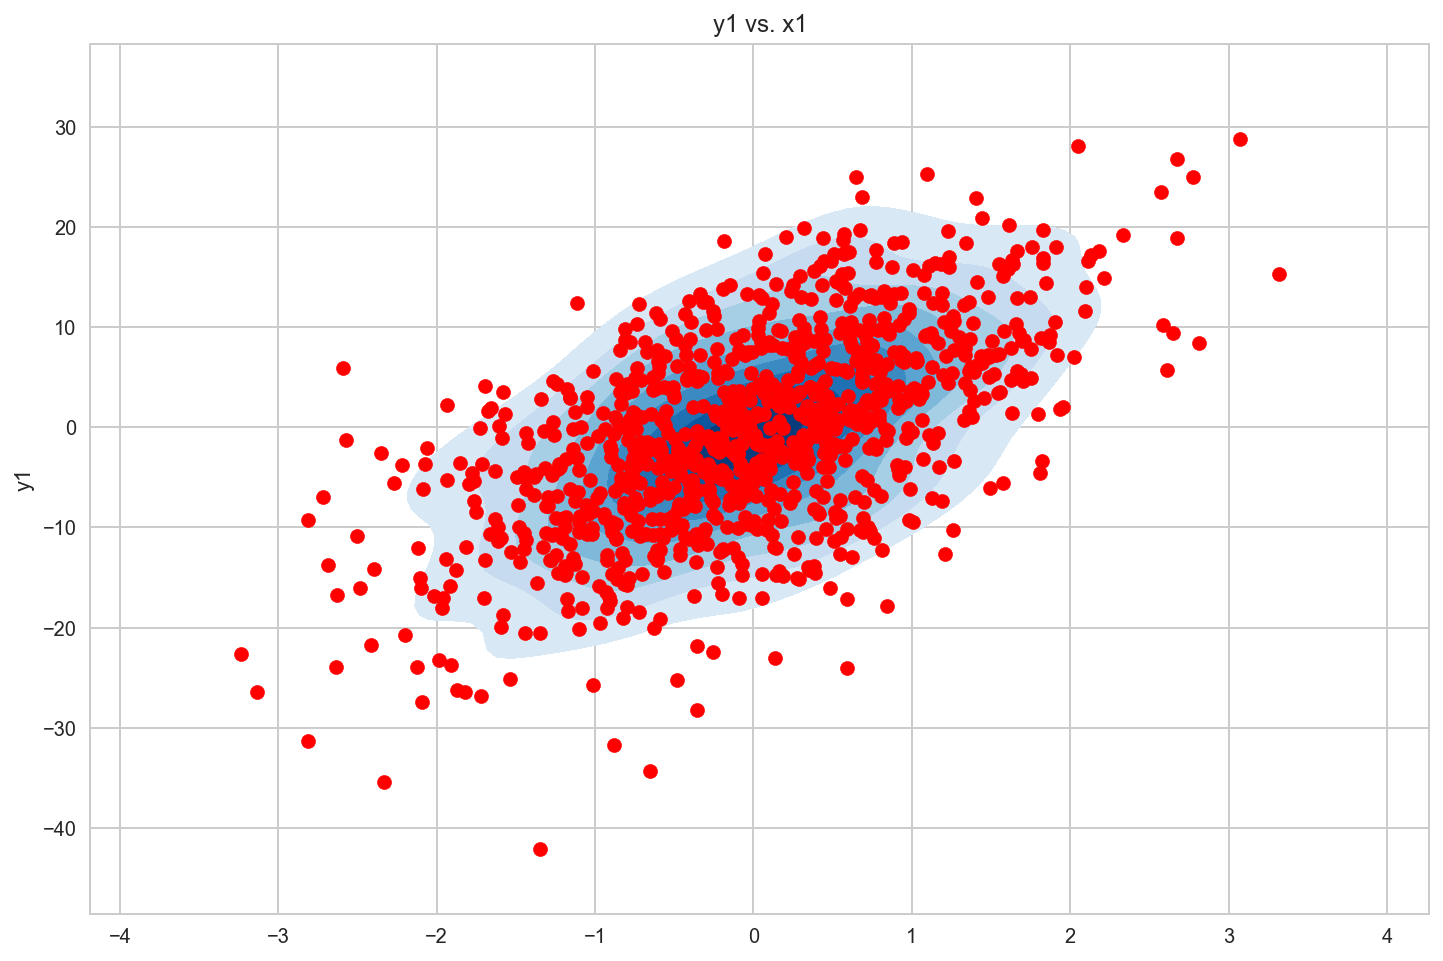

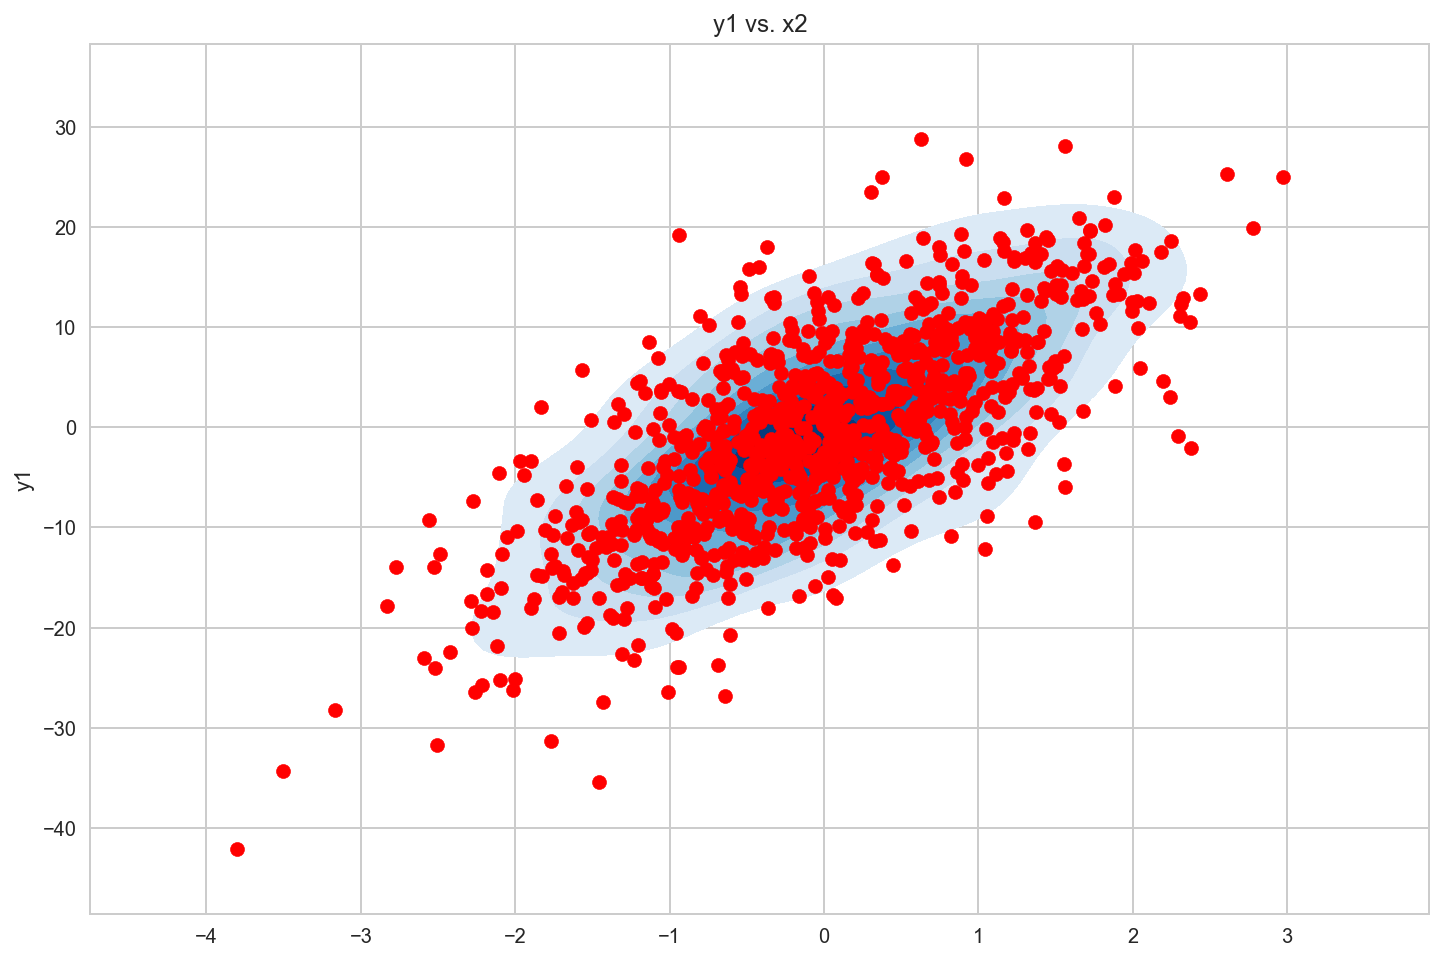

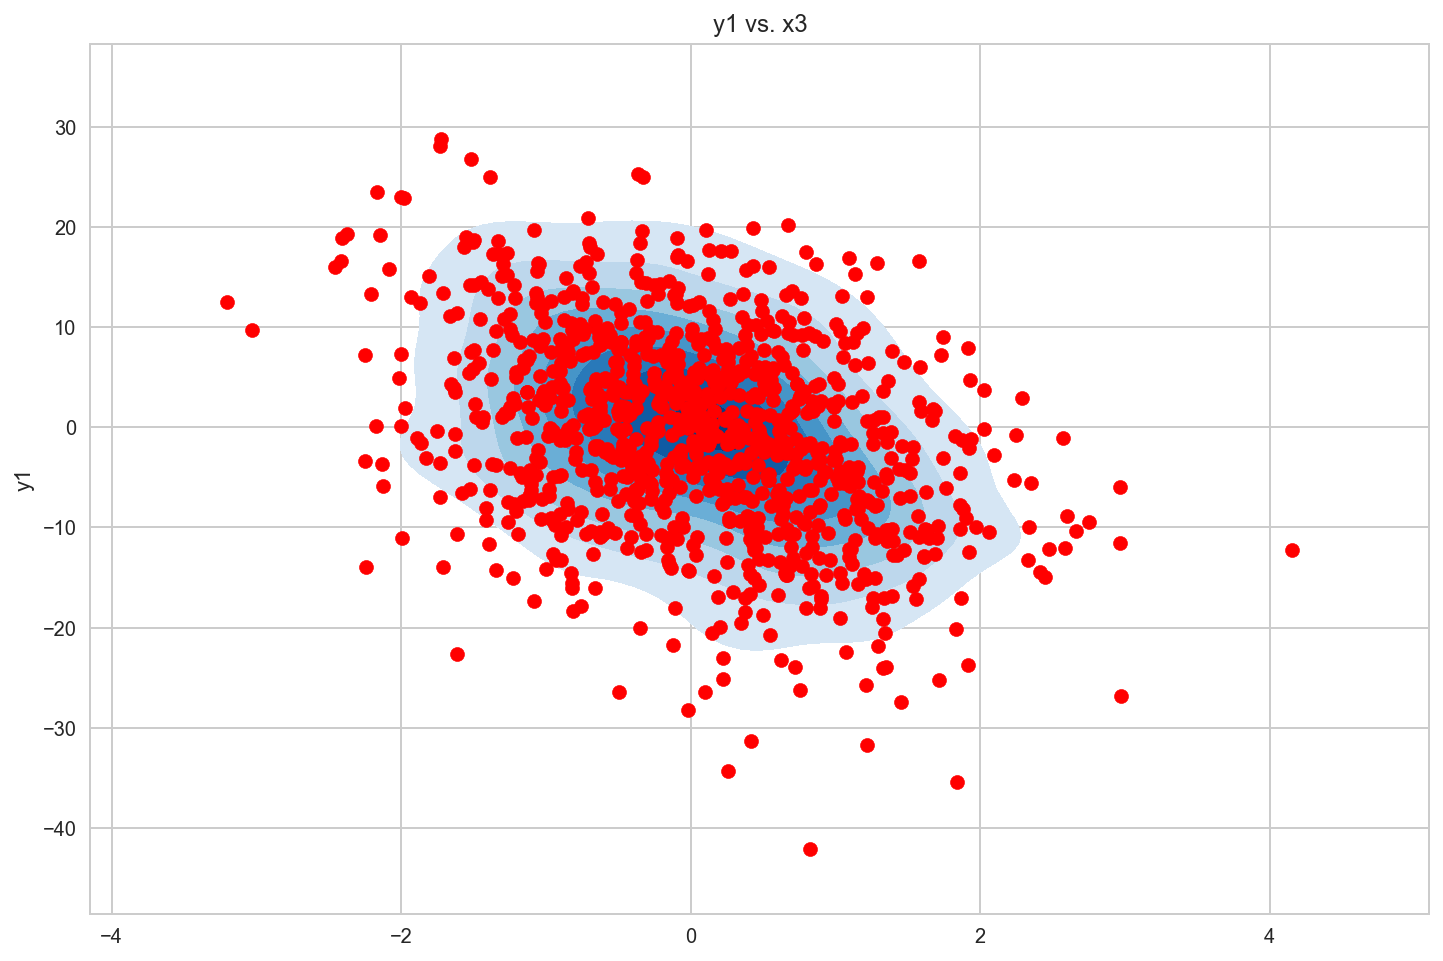

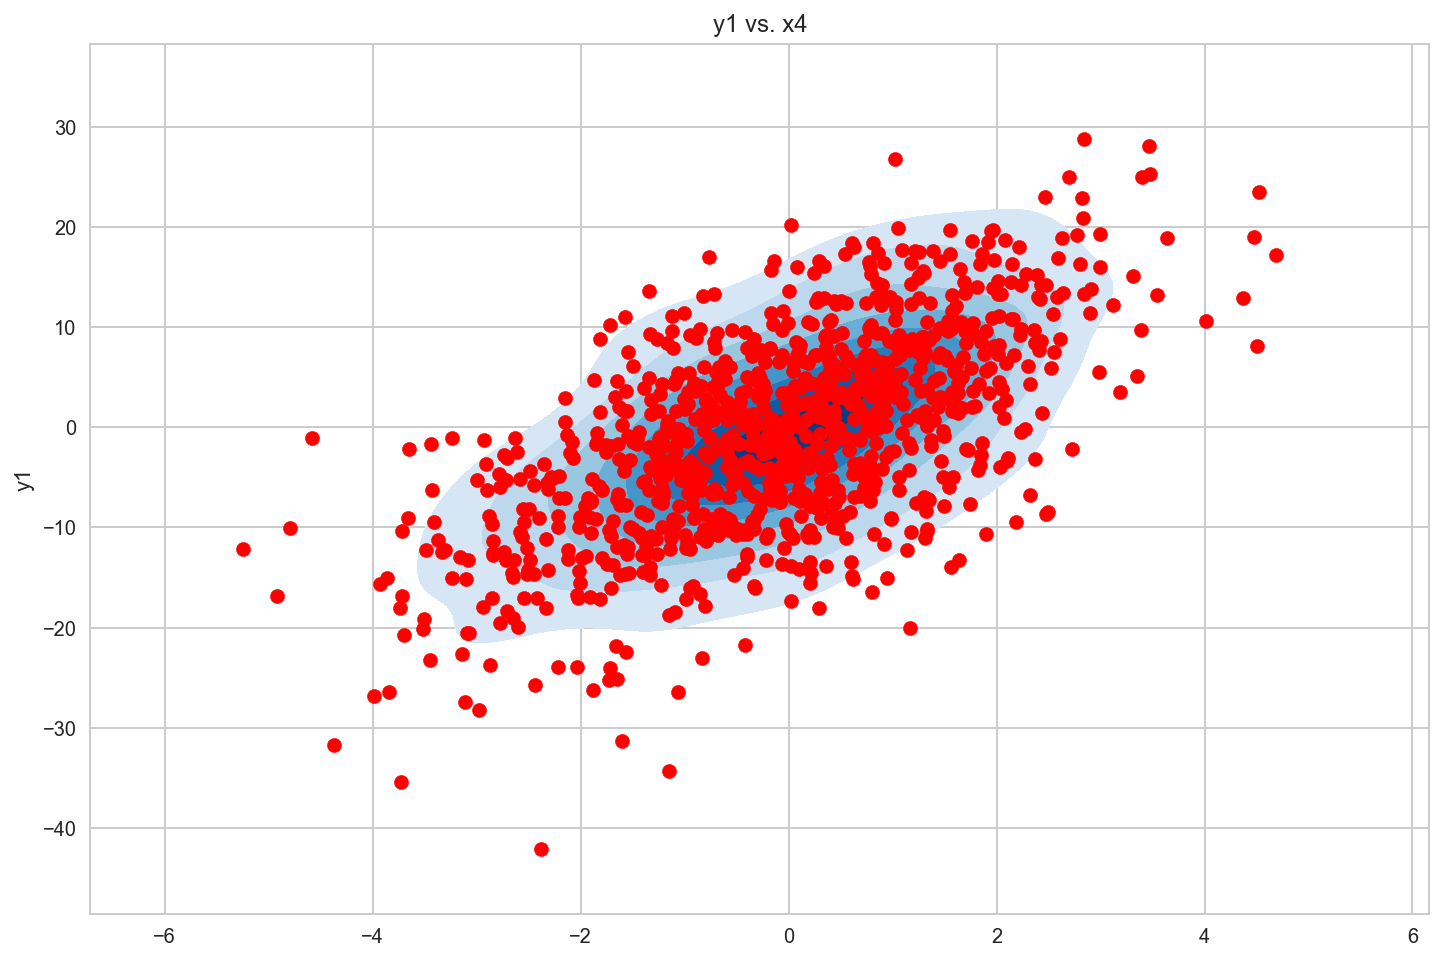

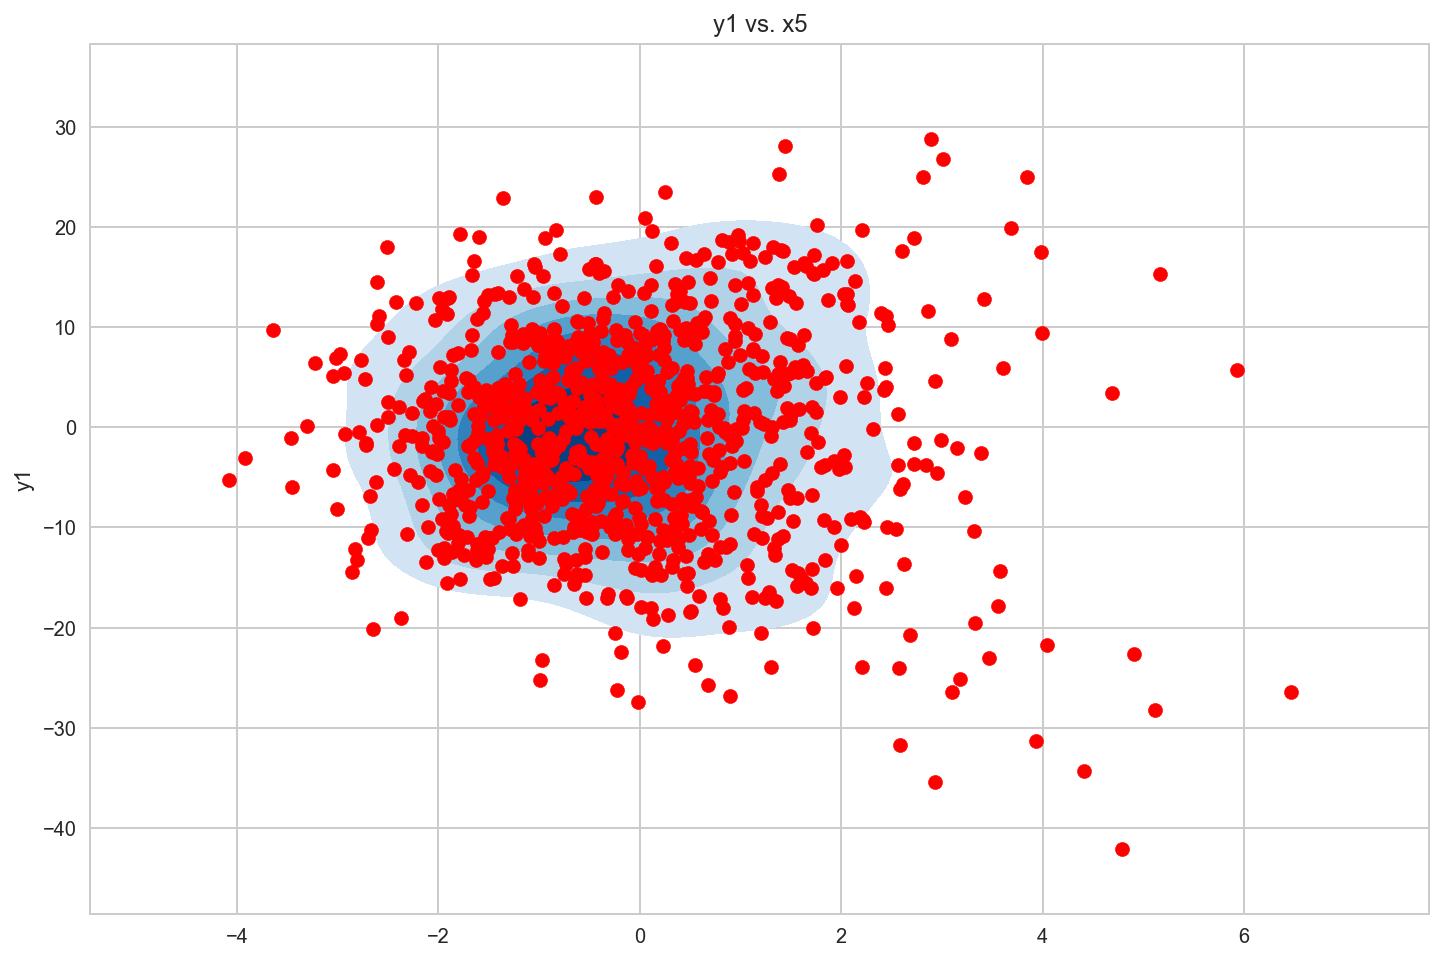

In [58]:
plt.title("y1 vs. x1")
sns.kdeplot(X_scaler.inverse_transform(X_val)[:, 0], y_val['y1'], cmap="Blues", shade=True, shade_lowest=False)
plt.scatter(X_scaler.inverse_transform(X_val)[:, 0], preds[:, 0], c='r')
plt.show()
plt.title("y1 vs. x2")
sns.kdeplot(X_scaler.inverse_transform(X_val)[:, 1], y_val['y1'], cmap="Blues", shade=True, shade_lowest=False)
plt.scatter(X_scaler.inverse_transform(X_val)[:, 1], preds[:, 0], c='r')
plt.show()
plt.title("y1 vs. x3")
sns.kdeplot(X_scaler.inverse_transform(X_val)[:, 2], y_val['y1'], cmap="Blues", shade=True, shade_lowest=False)
plt.scatter(X_scaler.inverse_transform(X_val)[:, 2], preds[:, 0], c='r')
plt.show()
plt.title("y1 vs. x4")
sns.kdeplot(X_scaler.inverse_transform(X_val)[:, 3], y_val['y1'], cmap="Blues", shade=True, shade_lowest=False)
plt.scatter(X_scaler.inverse_transform(X_val)[:, 3], preds[:, 0], c='r')
plt.show()
plt.title("y1 vs. x5")
sns.kdeplot(X_scaler.inverse_transform(X_val)[:, 4], y_val['y1'], cmap="Blues", shade=True, shade_lowest=False)
plt.scatter(X_scaler.inverse_transform(X_val)[:, 4], preds[:, 0], c='r')
plt.show()

### y2

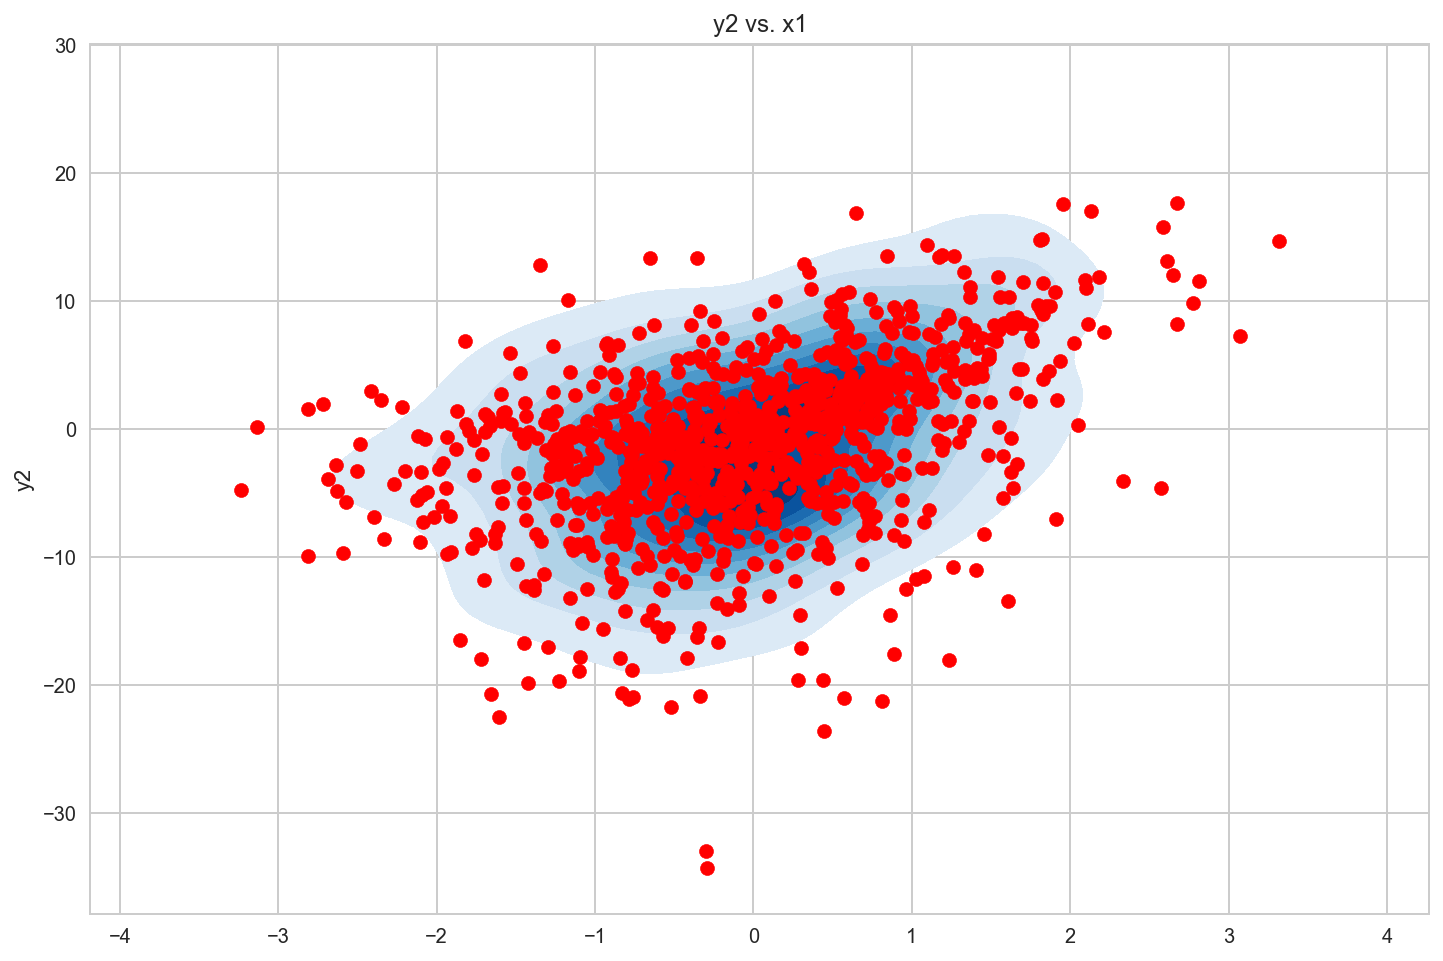

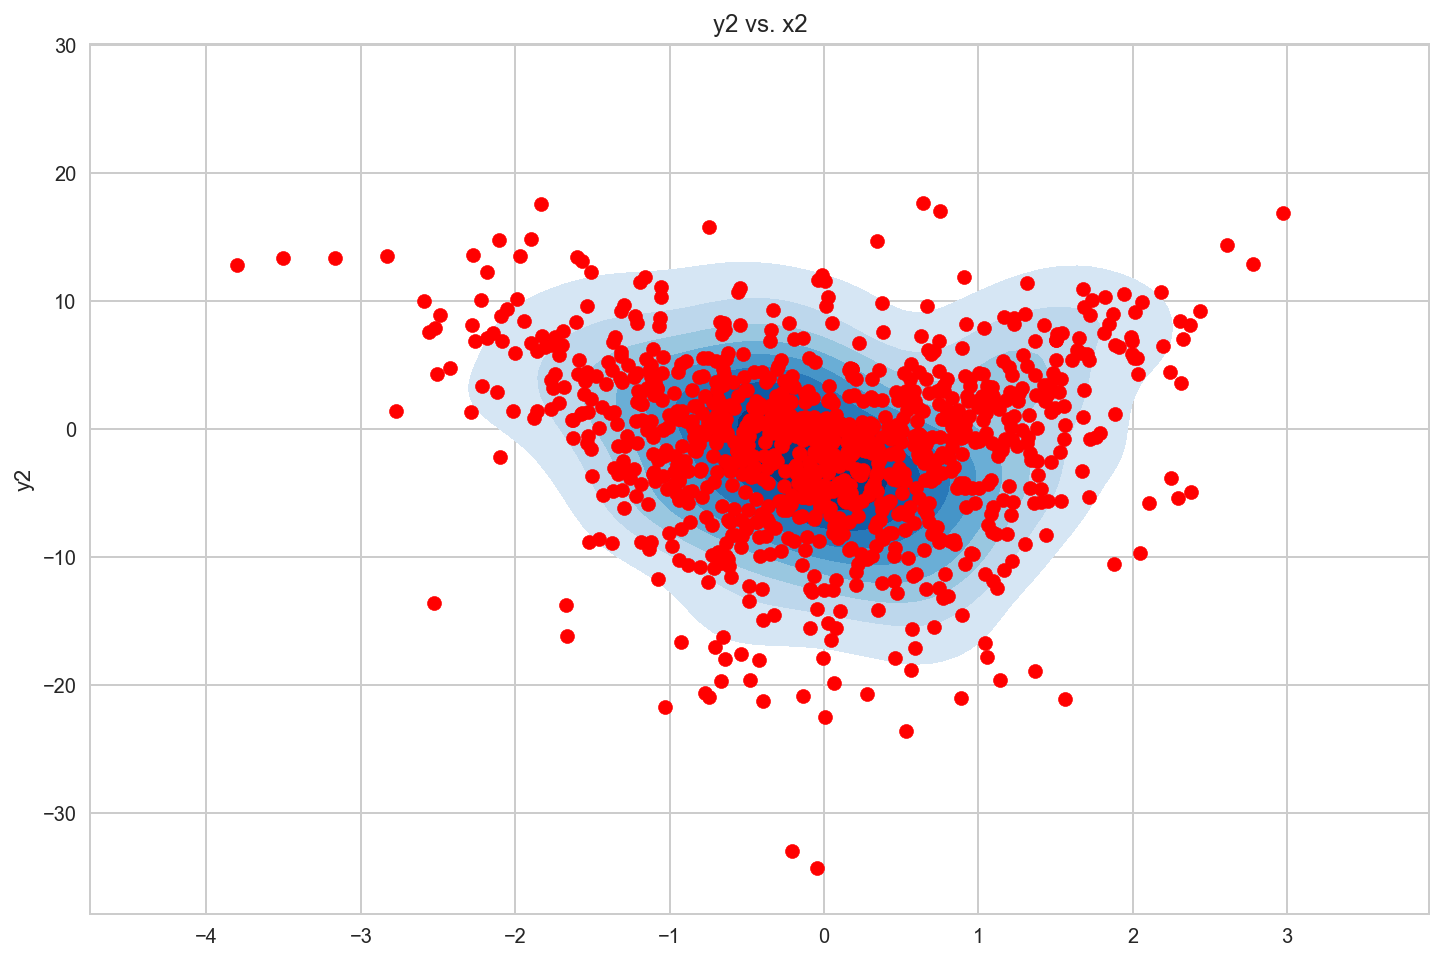

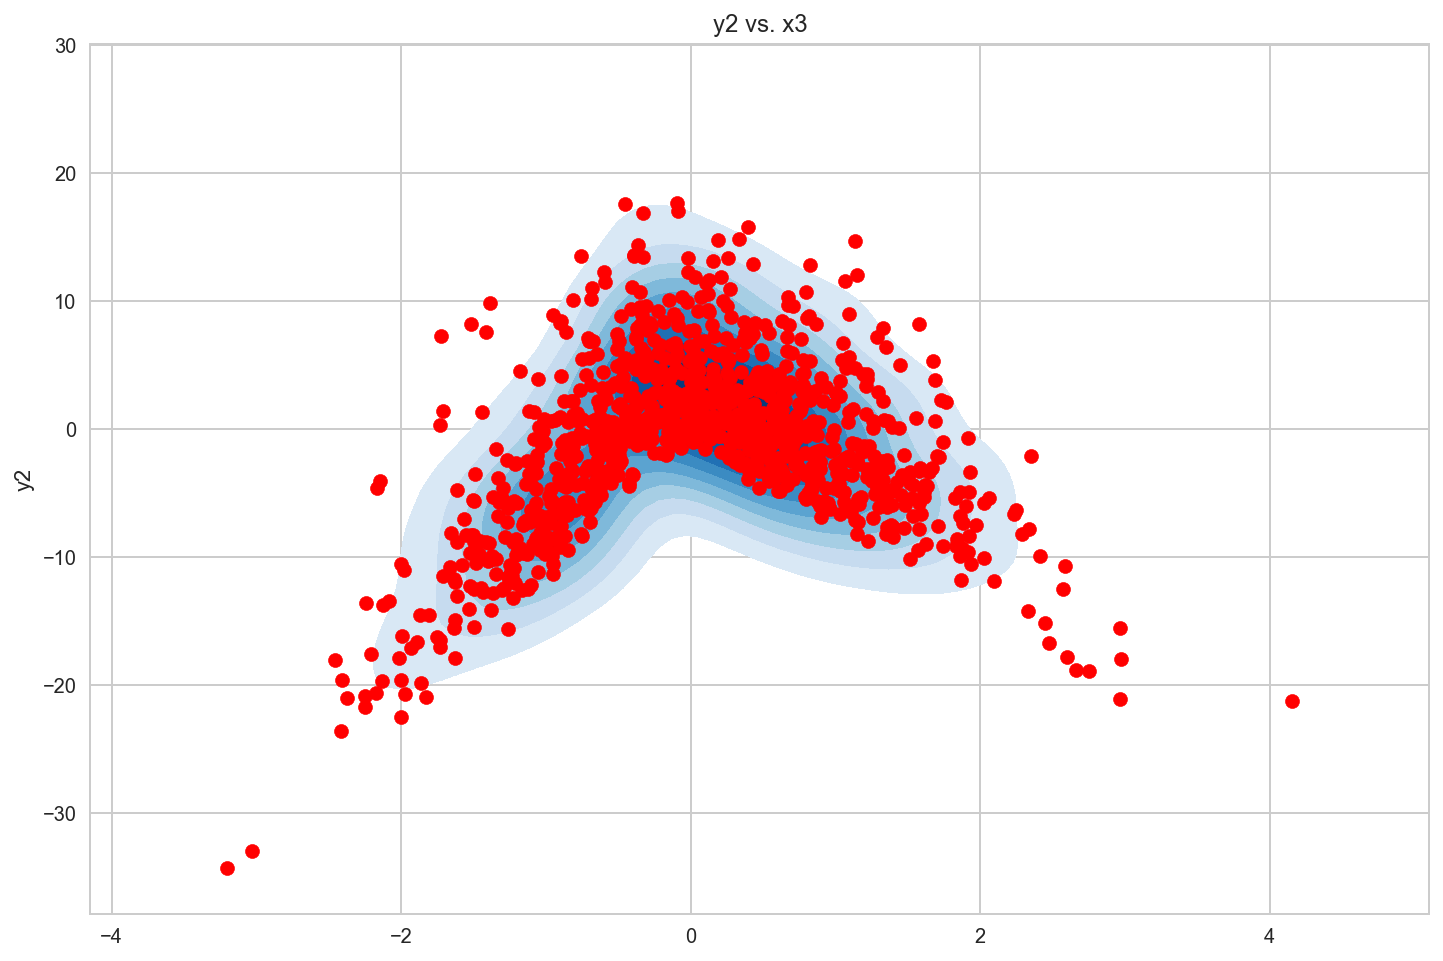

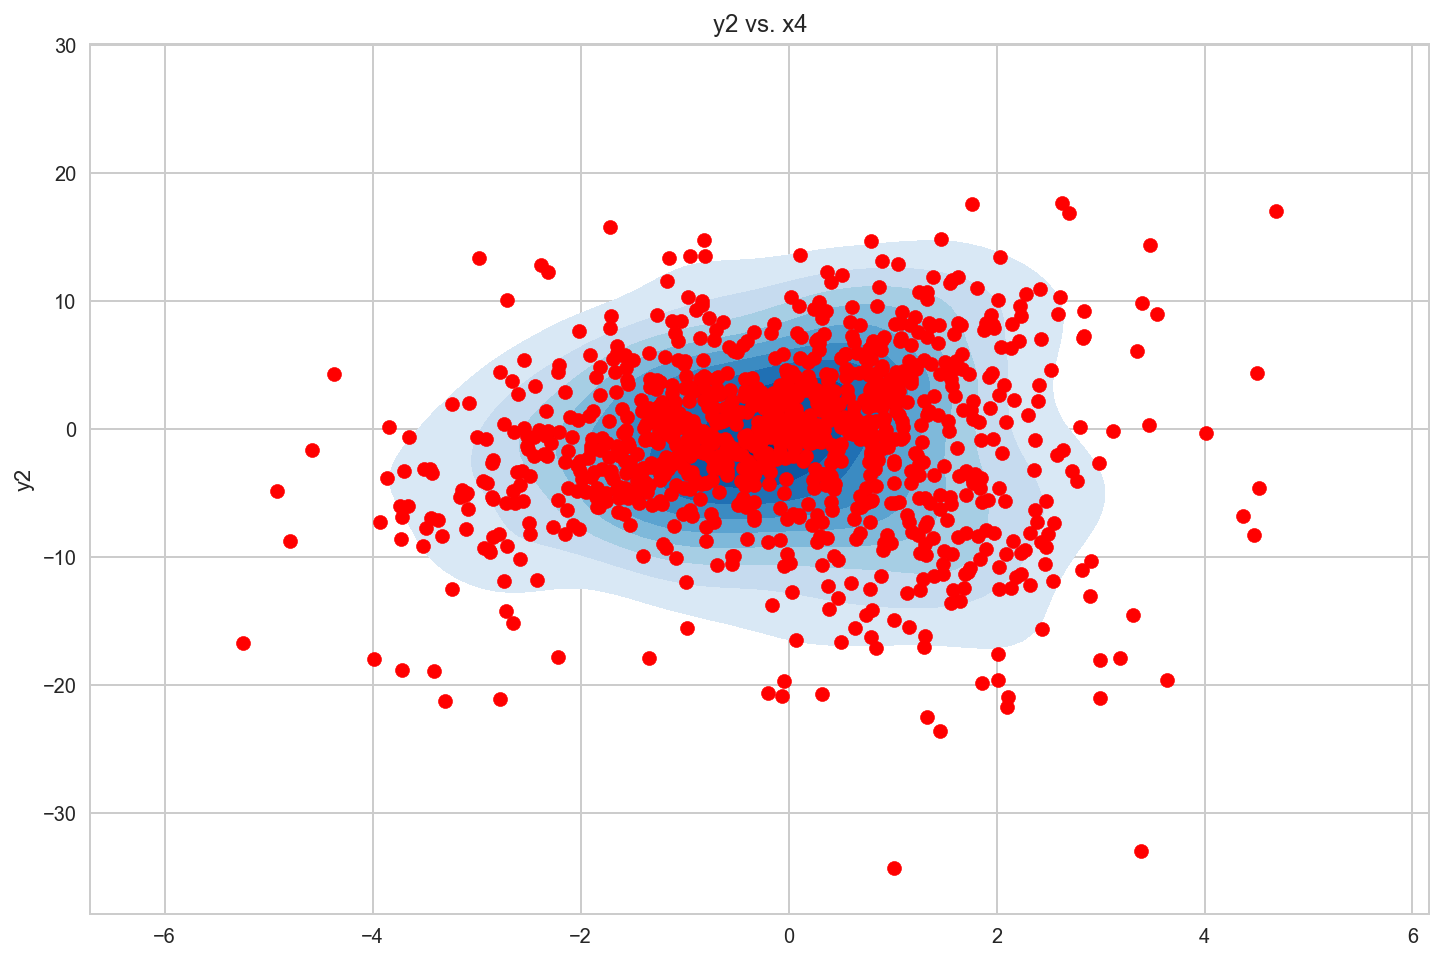

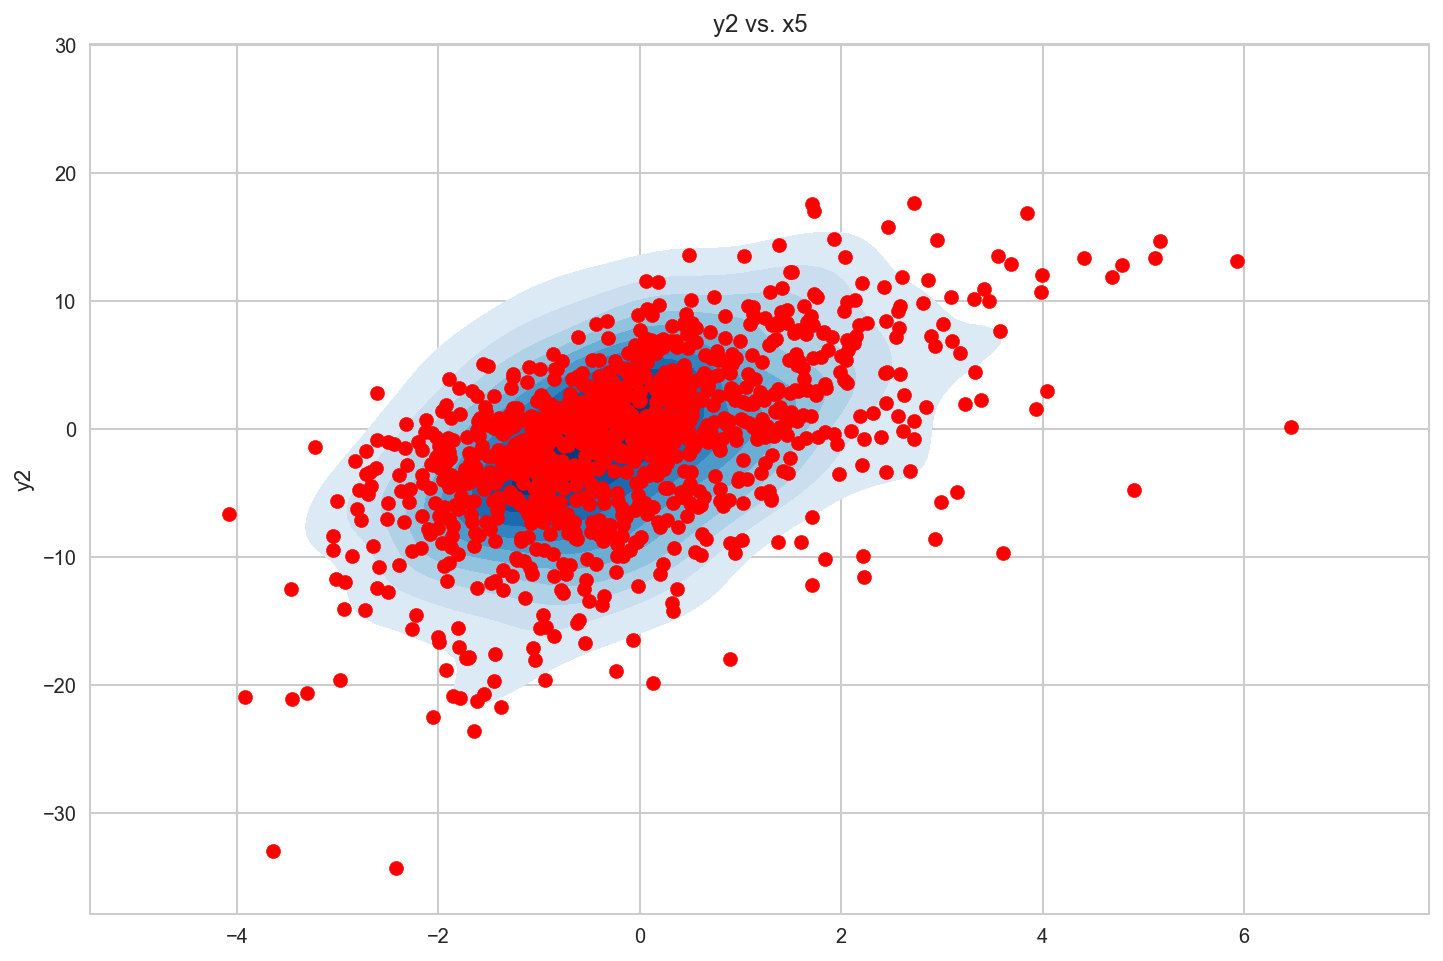

In [59]:
plt.title("y2 vs. x1")
sns.kdeplot(X_scaler.inverse_transform(X_val)[:, 0], y_val['y2'], cmap="Blues", shade=True, shade_lowest=False)
plt.scatter(X_scaler.inverse_transform(X_val)[:, 0], preds[:, 1], c='r')
plt.show()
plt.title("y2 vs. x2")
sns.kdeplot(X_scaler.inverse_transform(X_val)[:, 1], y_val['y2'], cmap="Blues", shade=True, shade_lowest=False)
plt.scatter(X_scaler.inverse_transform(X_val)[:, 1], preds[:, 1], c='r')
plt.show()
plt.title("y2 vs. x3")
sns.kdeplot(X_scaler.inverse_transform(X_val)[:, 2], y_val['y2'], cmap="Blues", shade=True, shade_lowest=False)
plt.scatter(X_scaler.inverse_transform(X_val)[:, 2], preds[:, 1], c='r')
plt.show()
plt.title("y2 vs. x4")
sns.kdeplot(X_scaler.inverse_transform(X_val)[:, 3], y_val['y2'], cmap="Blues", shade=True, shade_lowest=False)
plt.scatter(X_scaler.inverse_transform(X_val)[:, 3], preds[:, 1], c='r')
plt.show()
plt.title("y2 vs. x5")
sns.kdeplot(X_scaler.inverse_transform(X_val)[:, 4], y_val['y2'], cmap="Blues", shade=True, shade_lowest=False)
plt.scatter(X_scaler.inverse_transform(X_val)[:, 4], preds[:, 1], c='r')
plt.show()

### y3

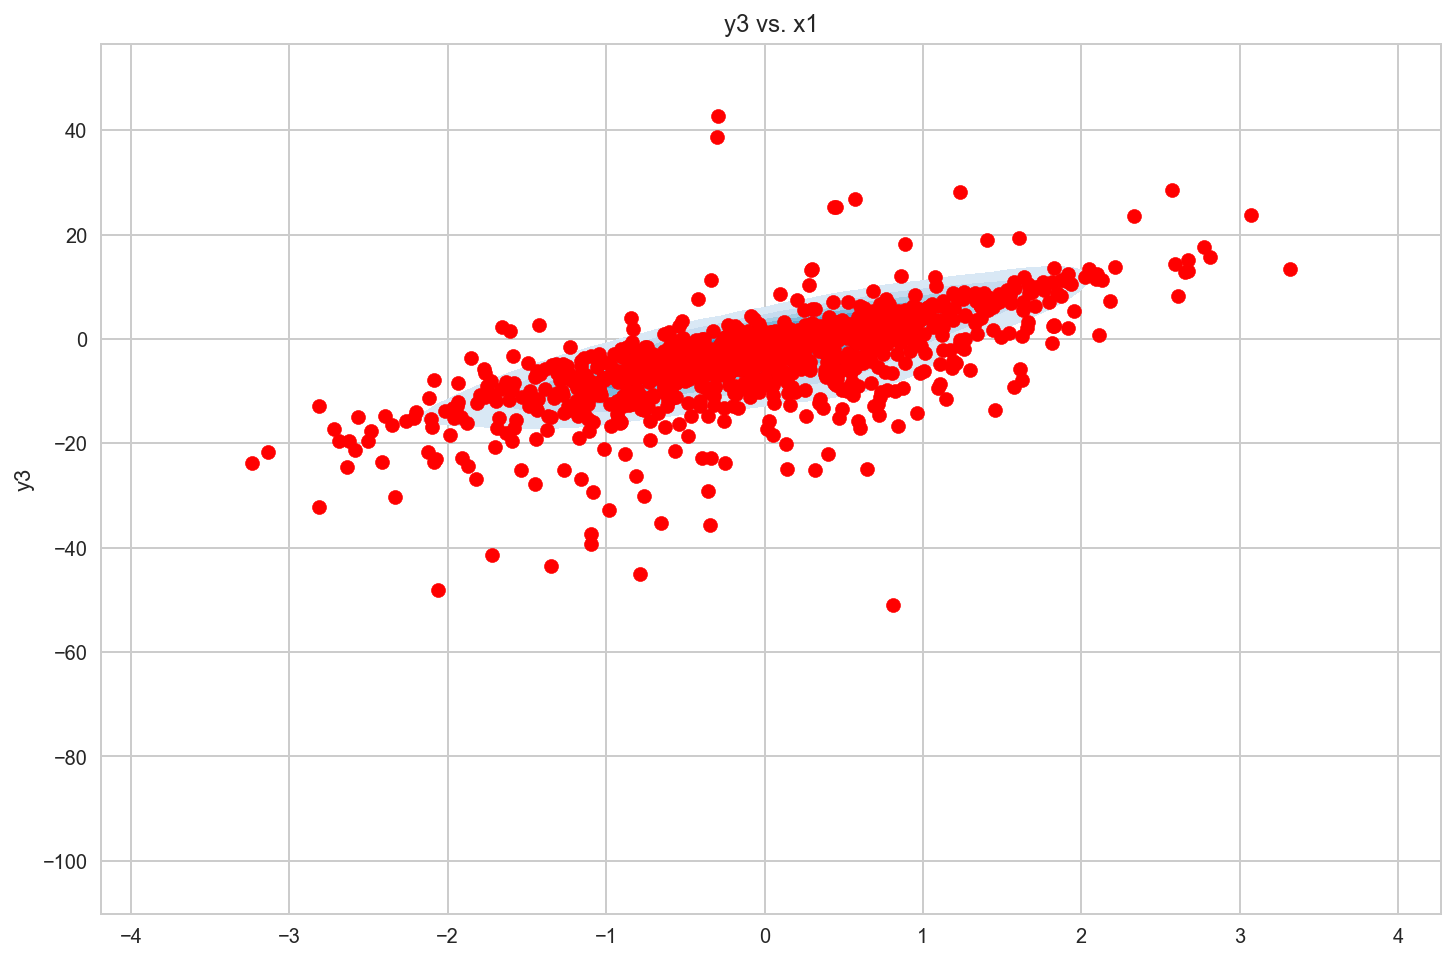

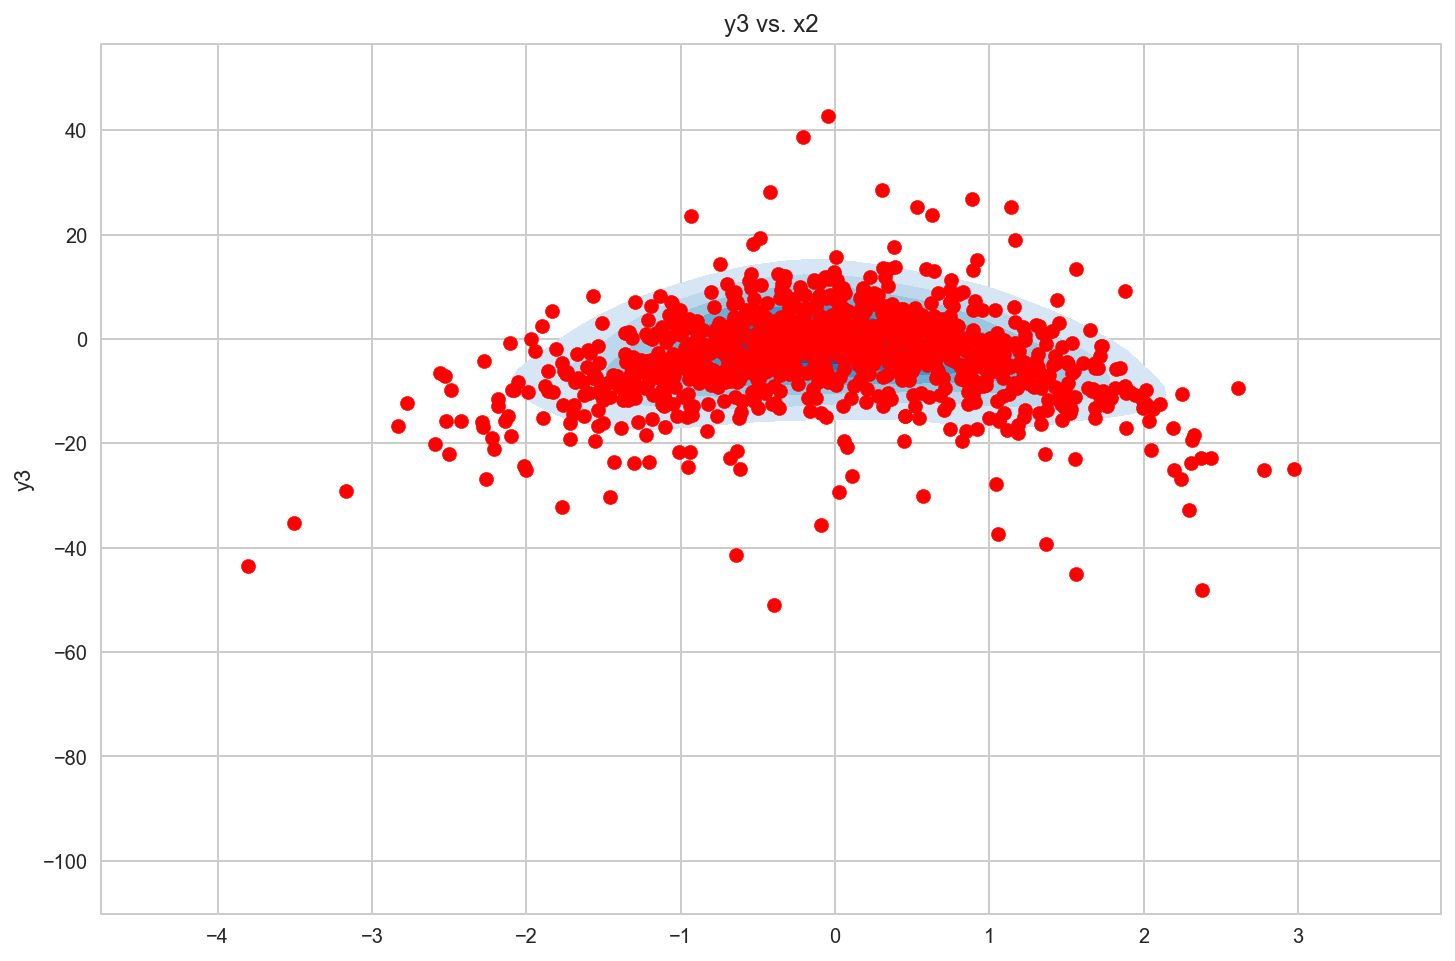

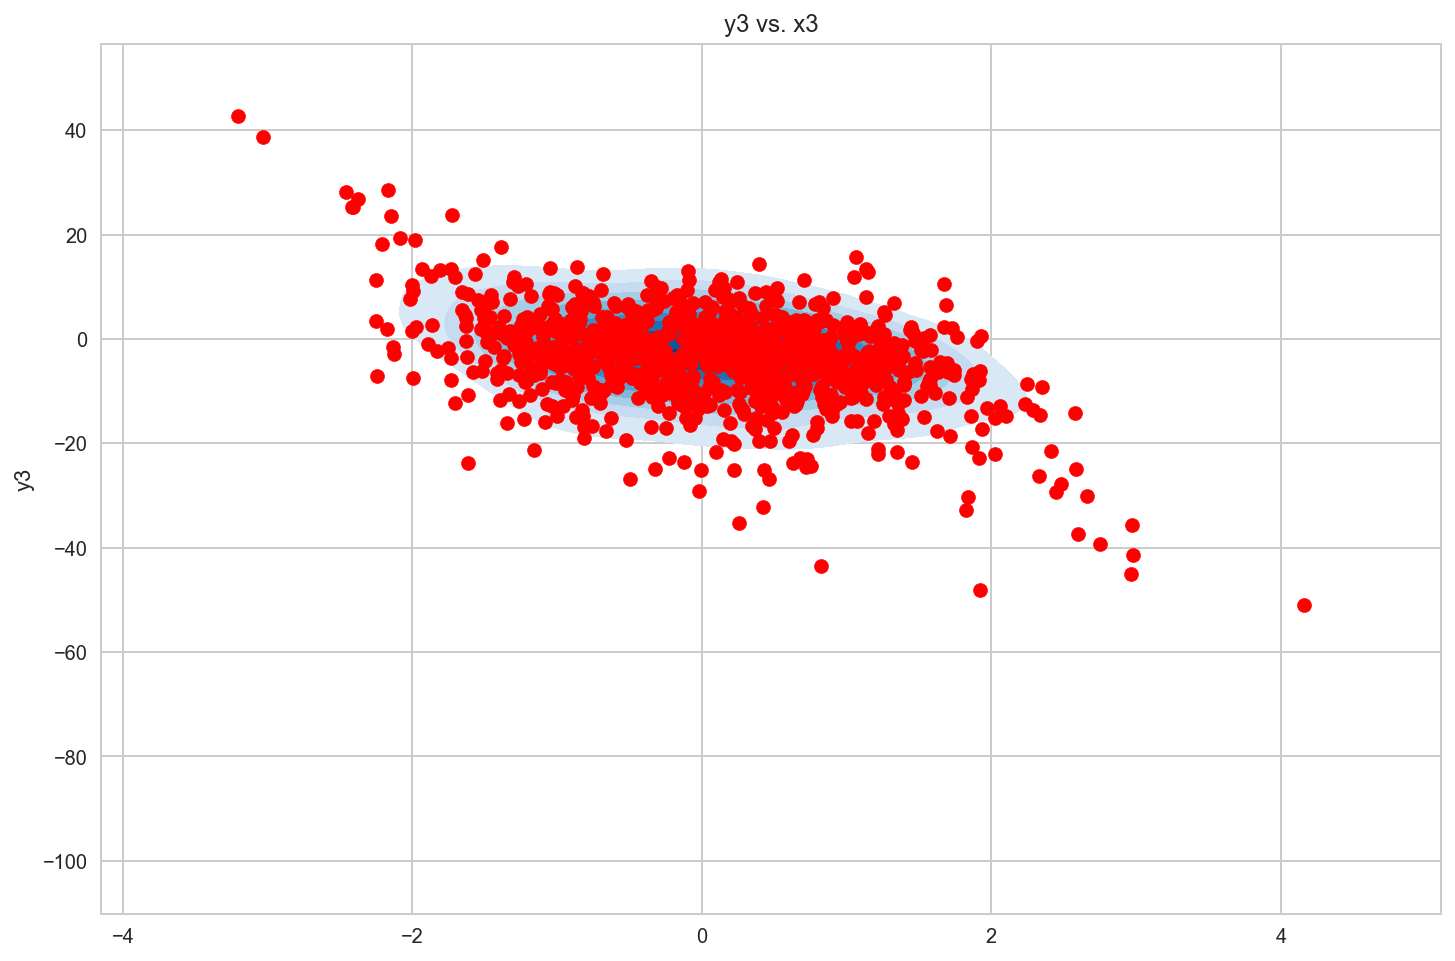

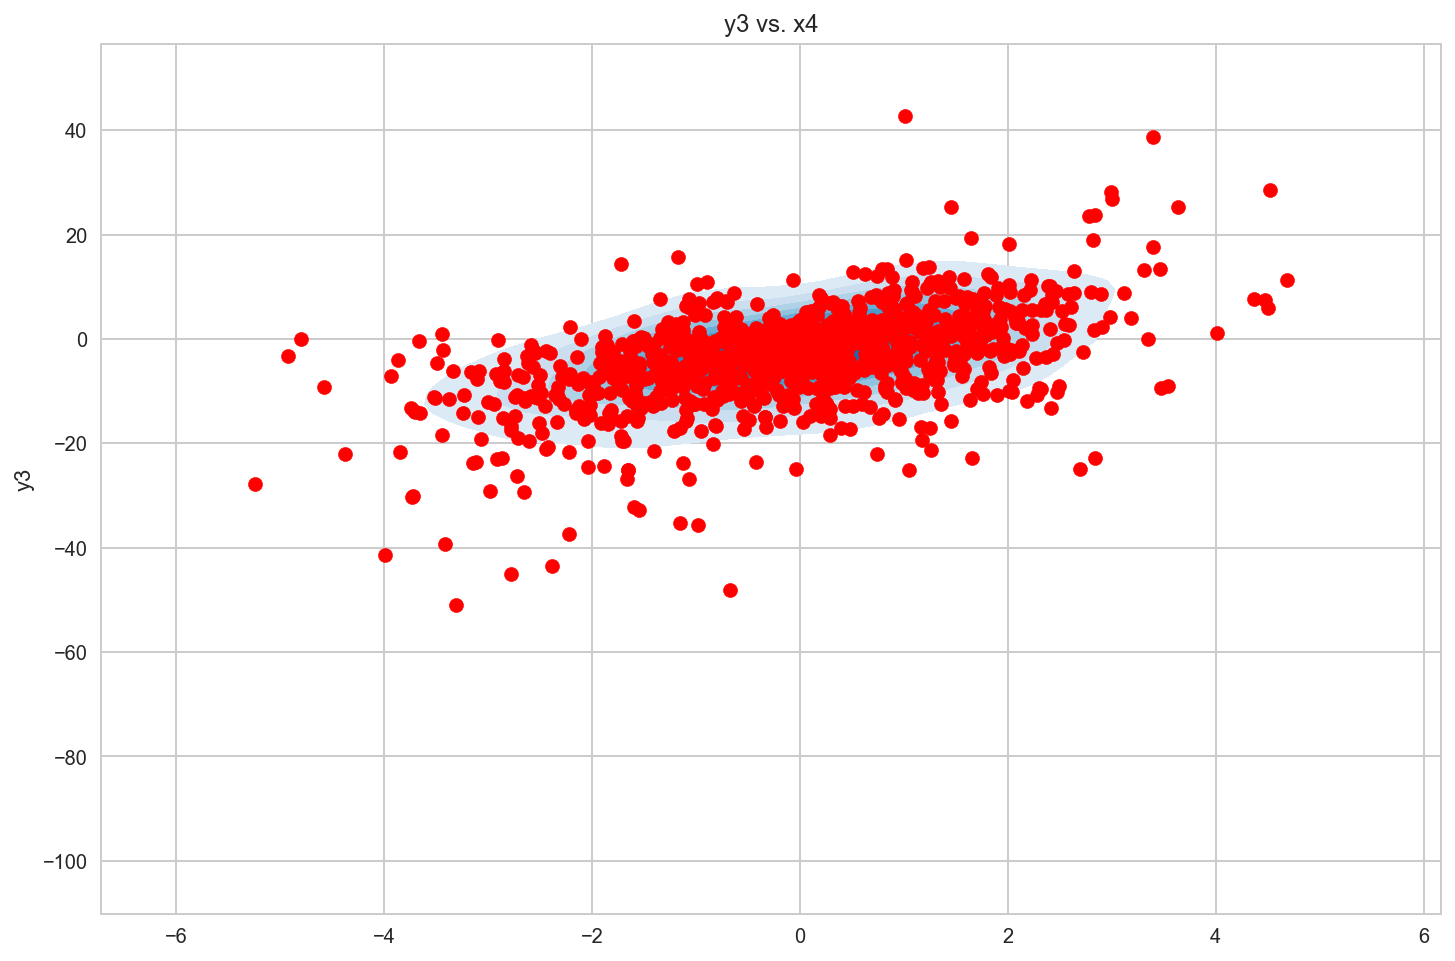

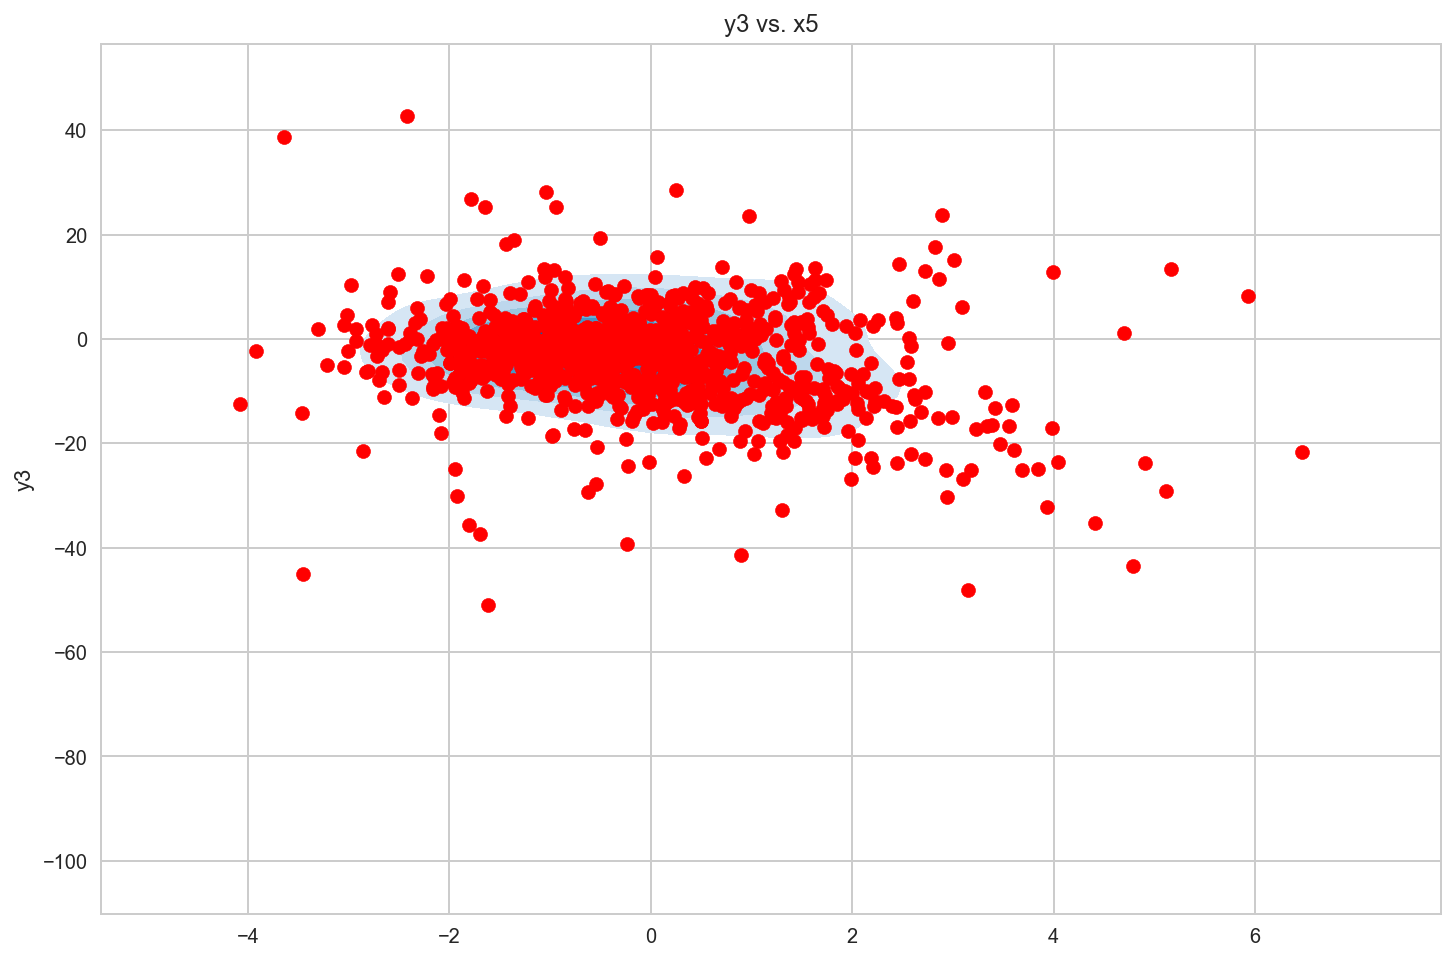

In [60]:
plt.title("y3 vs. x1")
sns.kdeplot(X_scaler.inverse_transform(X_val)[:, 0], y_val['y3'], cmap="Blues", shade=True, shade_lowest=False)
plt.scatter(X_scaler.inverse_transform(X_val)[:, 0], preds[:, 2], c='r')
plt.show()
plt.title("y3 vs. x2")
sns.kdeplot(X_scaler.inverse_transform(X_val)[:, 1], y_val['y3'], cmap="Blues", shade=True, shade_lowest=False)
plt.scatter(X_scaler.inverse_transform(X_val)[:, 1], preds[:, 2], c='r')
plt.show()
plt.title("y3 vs. x3")
sns.kdeplot(X_scaler.inverse_transform(X_val)[:, 2], y_val['y3'], cmap="Blues", shade=True, shade_lowest=False)
plt.scatter(X_scaler.inverse_transform(X_val)[:, 2], preds[:, 2], c='r')
plt.show()
plt.title("y3 vs. x4")
sns.kdeplot(X_scaler.inverse_transform(X_val)[:, 3], y_val['y3'], cmap="Blues", shade=True, shade_lowest=False)
plt.scatter(X_scaler.inverse_transform(X_val)[:, 3], preds[:, 2], c='r')
plt.show()
plt.title("y3 vs. x5")
sns.kdeplot(X_scaler.inverse_transform(X_val)[:, 4], y_val['y3'], cmap="Blues", shade=True, shade_lowest=False)
plt.scatter(X_scaler.inverse_transform(X_val)[:, 4], preds[:, 2], c='r')
plt.show()

### y4

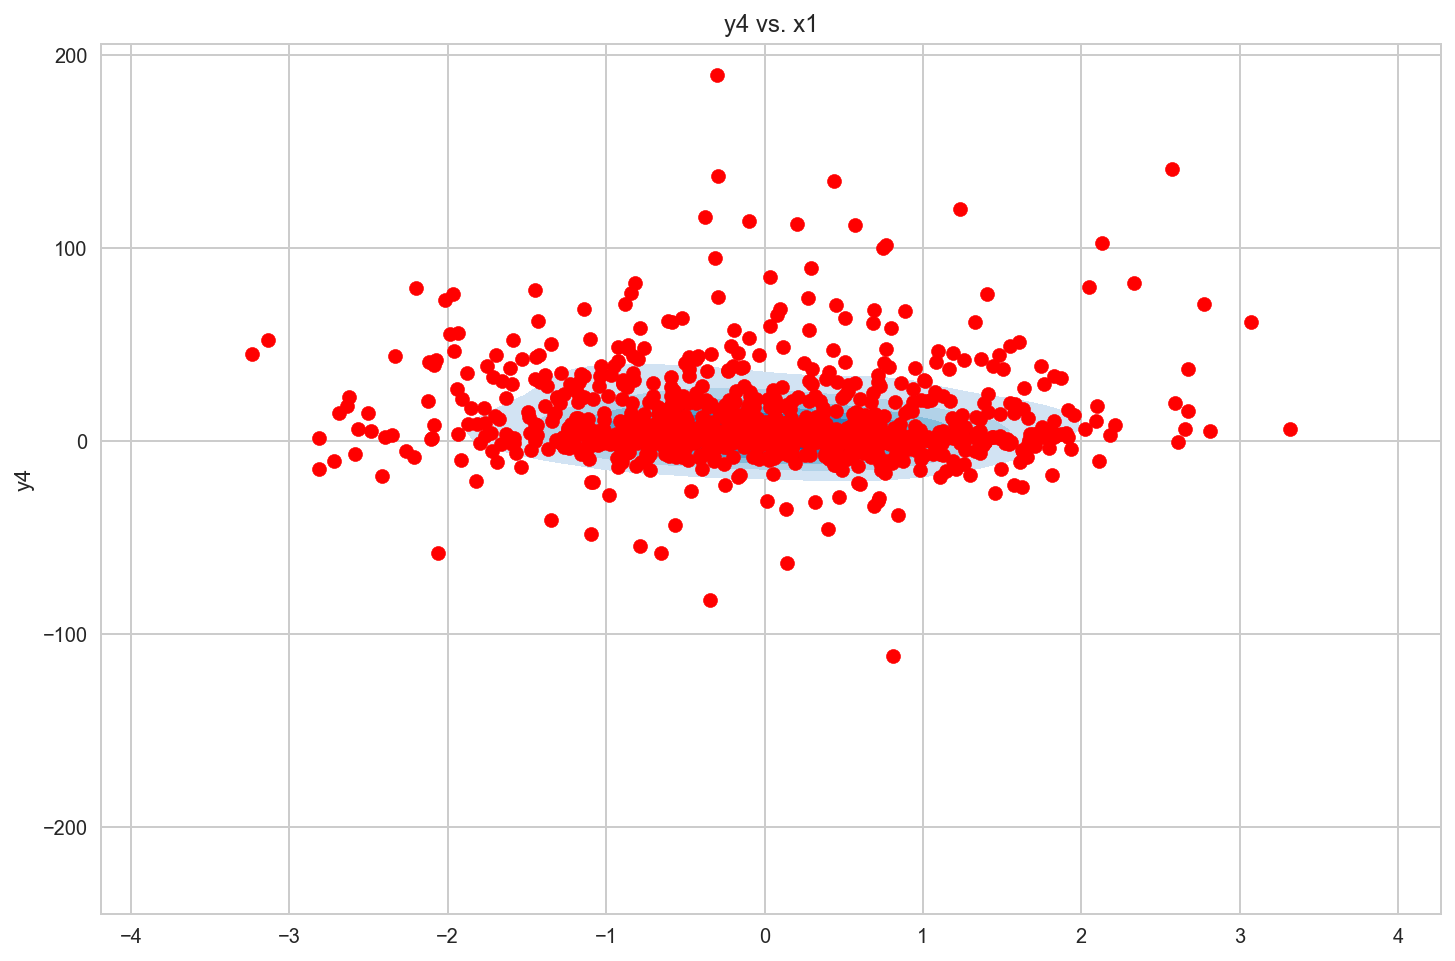

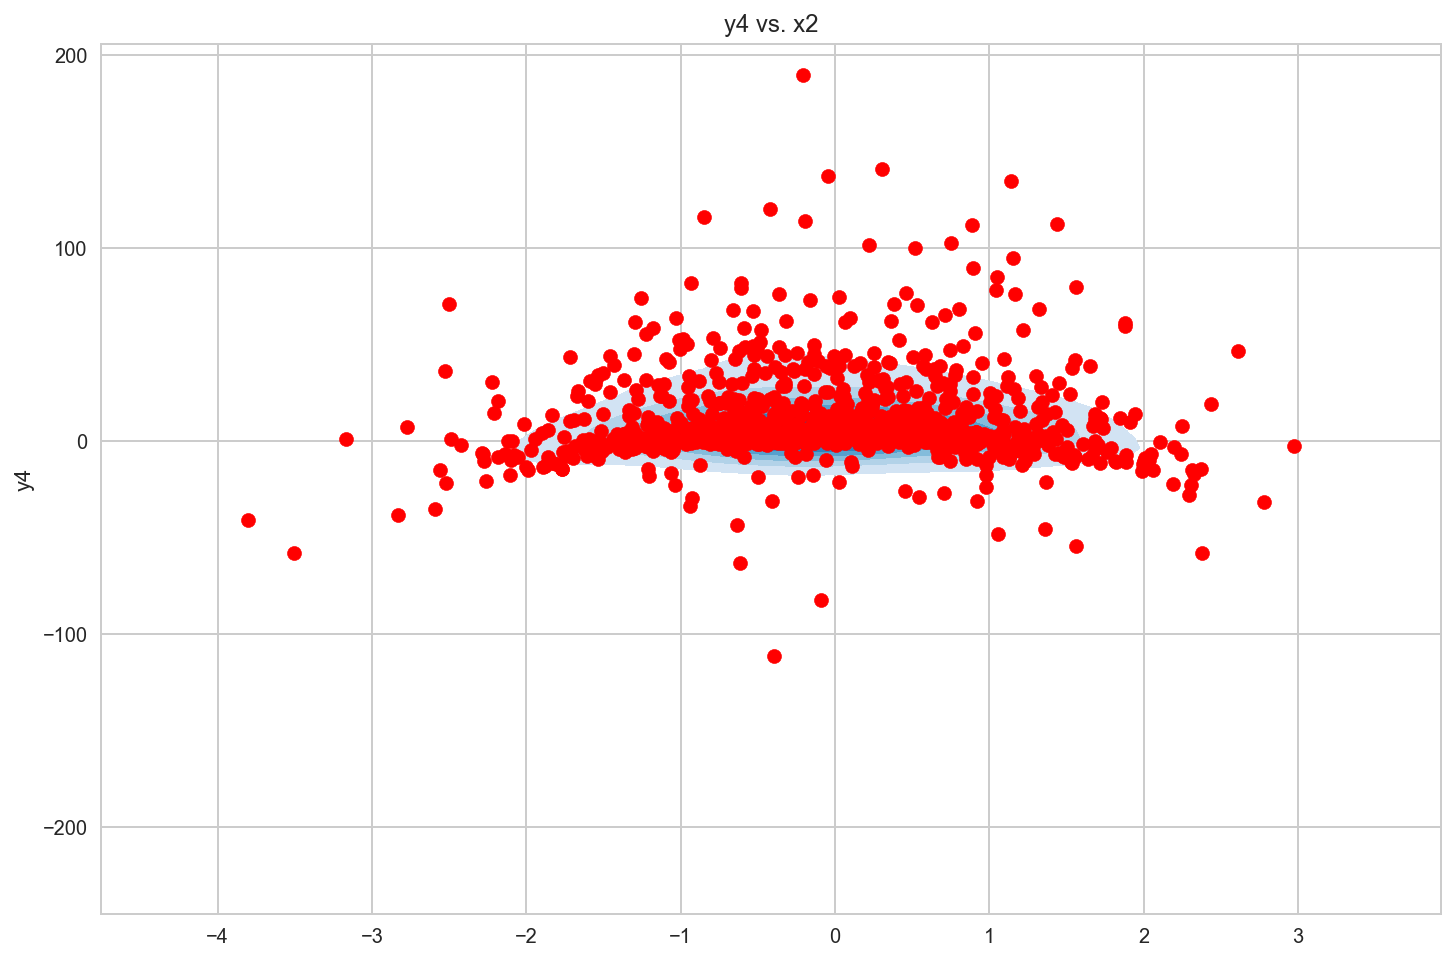

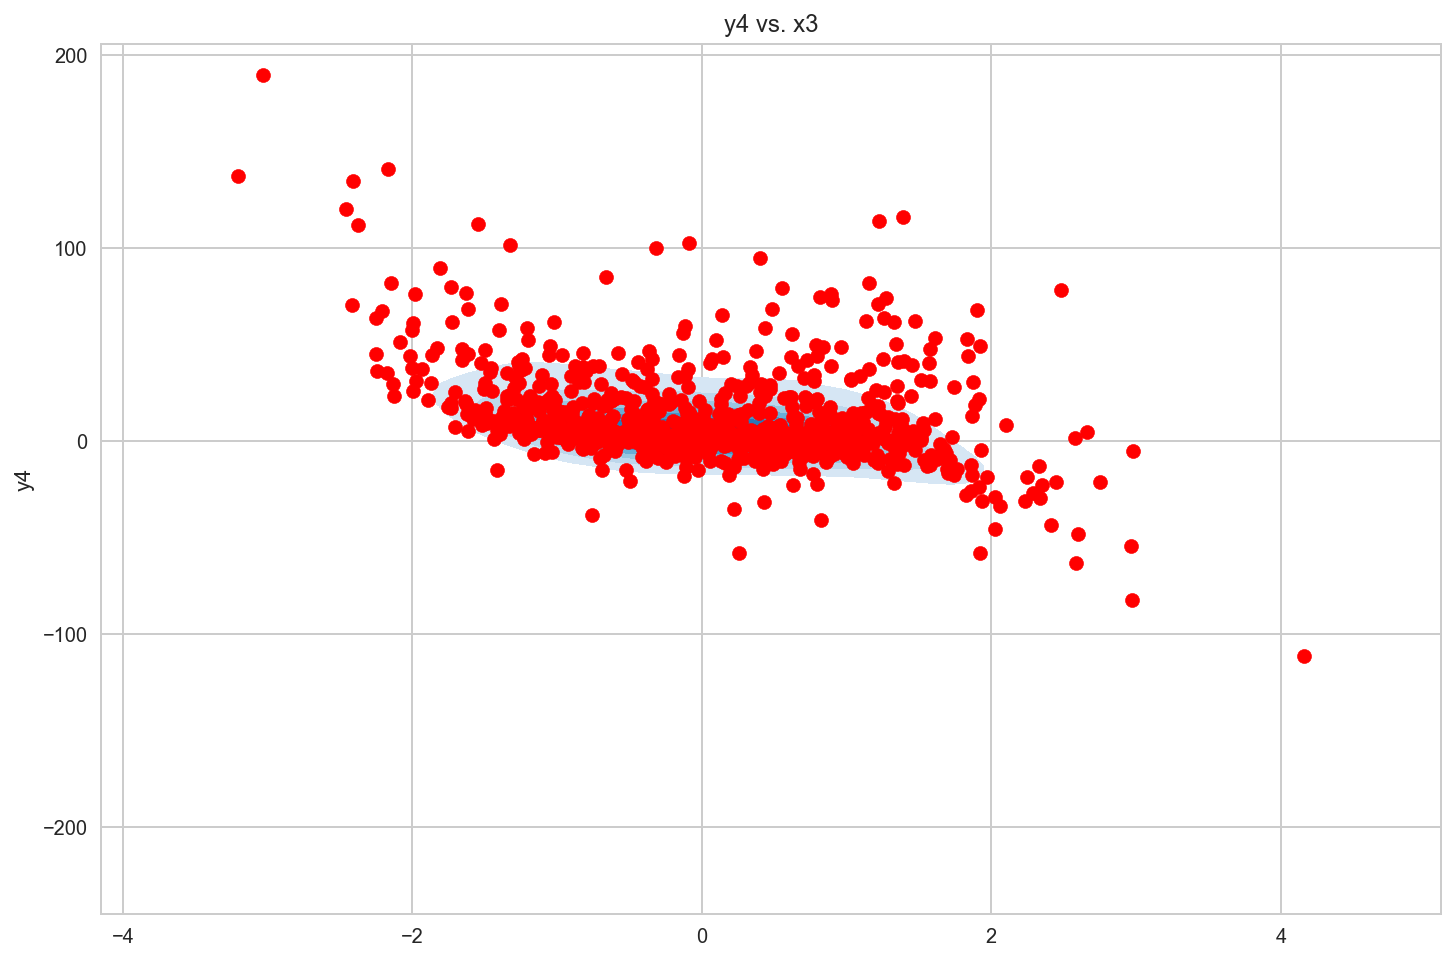

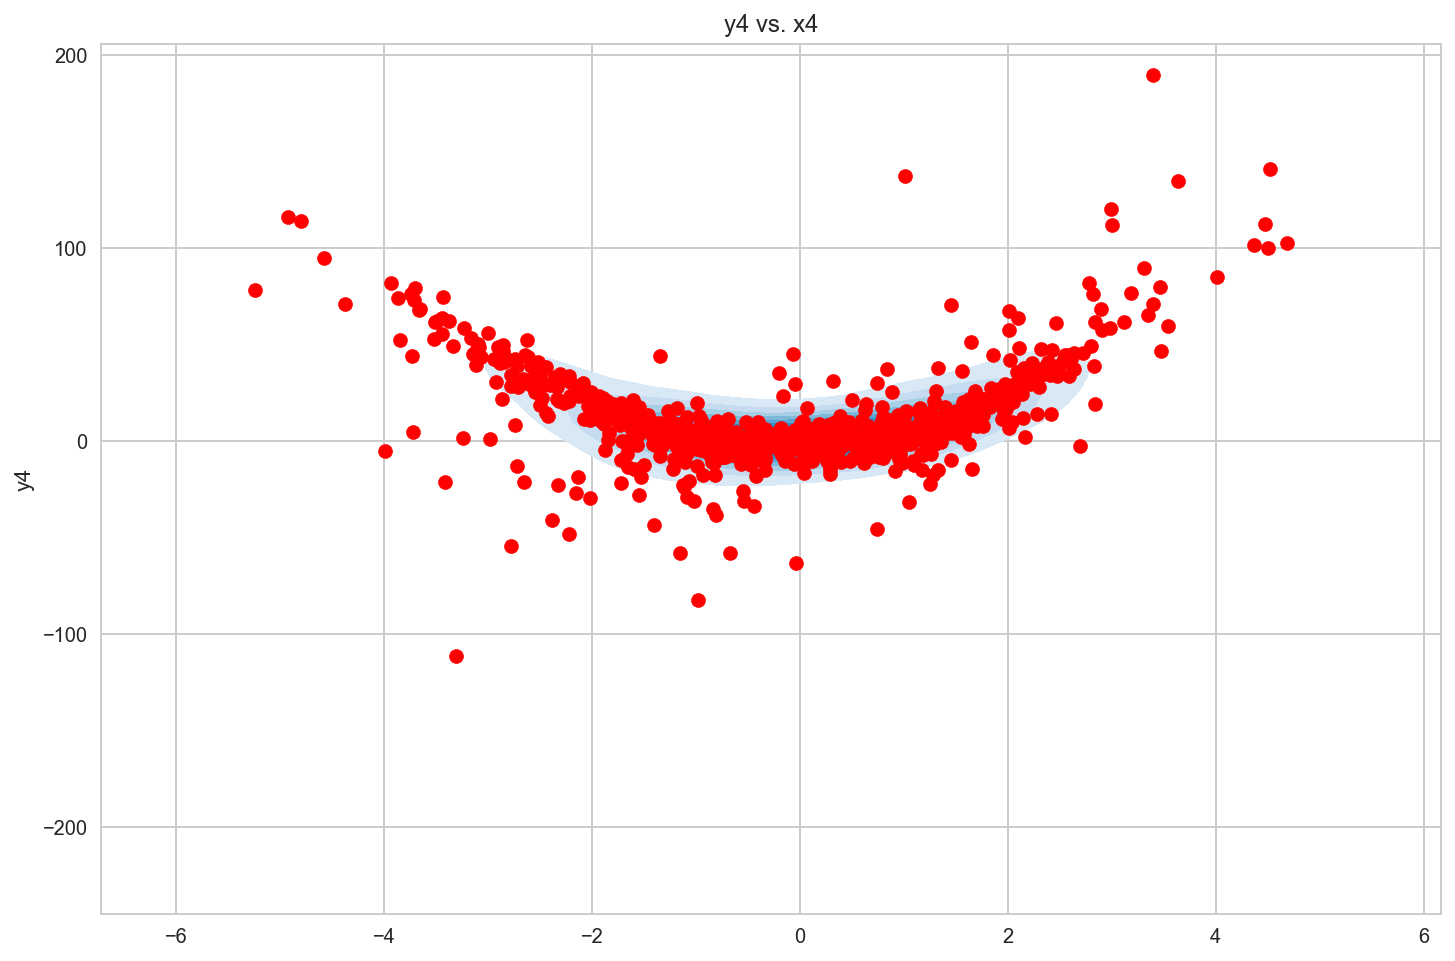

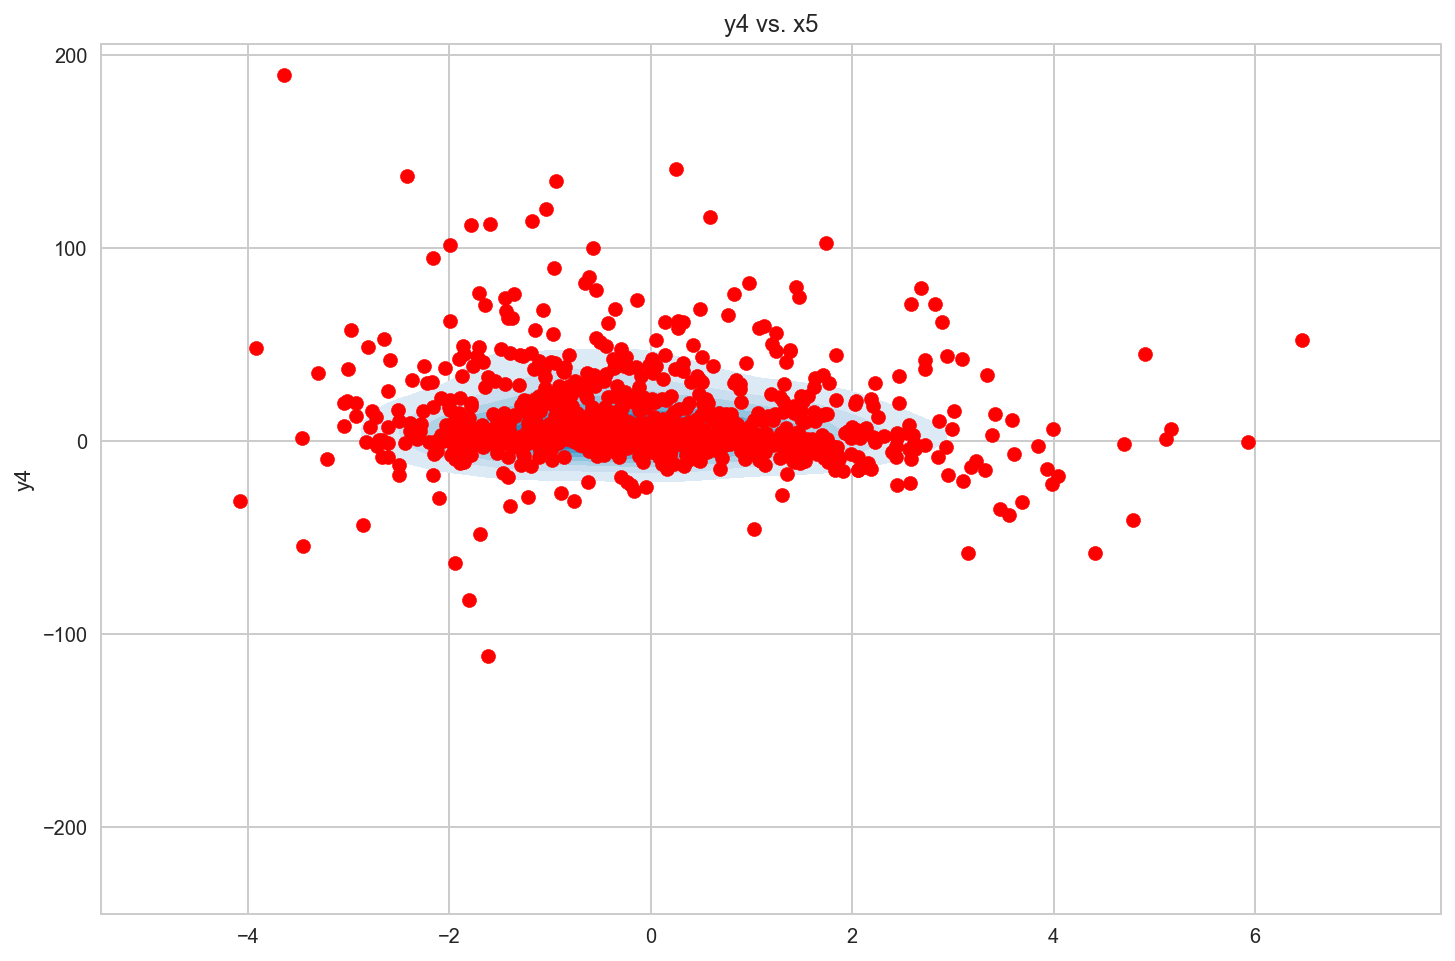

In [61]:
plt.title("y4 vs. x1")
sns.kdeplot(X_scaler.inverse_transform(X_val)[:, 0], y_val['y4'], cmap="Blues", shade=True, shade_lowest=False)
plt.scatter(X_scaler.inverse_transform(X_val)[:, 0], preds[:, 3], c='r')
plt.show()
plt.title("y4 vs. x2")
sns.kdeplot(X_scaler.inverse_transform(X_val)[:, 1], y_val['y4'], cmap="Blues", shade=True, shade_lowest=False)
plt.scatter(X_scaler.inverse_transform(X_val)[:, 1], preds[:, 3], c='r')
plt.show()
plt.title("y4 vs. x3")
sns.kdeplot(X_scaler.inverse_transform(X_val)[:, 2], y_val['y4'], cmap="Blues", shade=True, shade_lowest=False)
plt.scatter(X_scaler.inverse_transform(X_val)[:, 2], preds[:, 3], c='r')
plt.show()
plt.title("y4 vs. x4")
sns.kdeplot(X_scaler.inverse_transform(X_val)[:, 3], y_val['y4'], cmap="Blues", shade=True, shade_lowest=False)
plt.scatter(X_scaler.inverse_transform(X_val)[:, 3], preds[:, 3], c='r')
plt.show()
plt.title("y4 vs. x5")
sns.kdeplot(X_scaler.inverse_transform(X_val)[:, 4], y_val['y4'], cmap="Blues", shade=True, shade_lowest=False)
plt.scatter(X_scaler.inverse_transform(X_val)[:, 4], preds[:, 3], c='r')
plt.show()

### y5

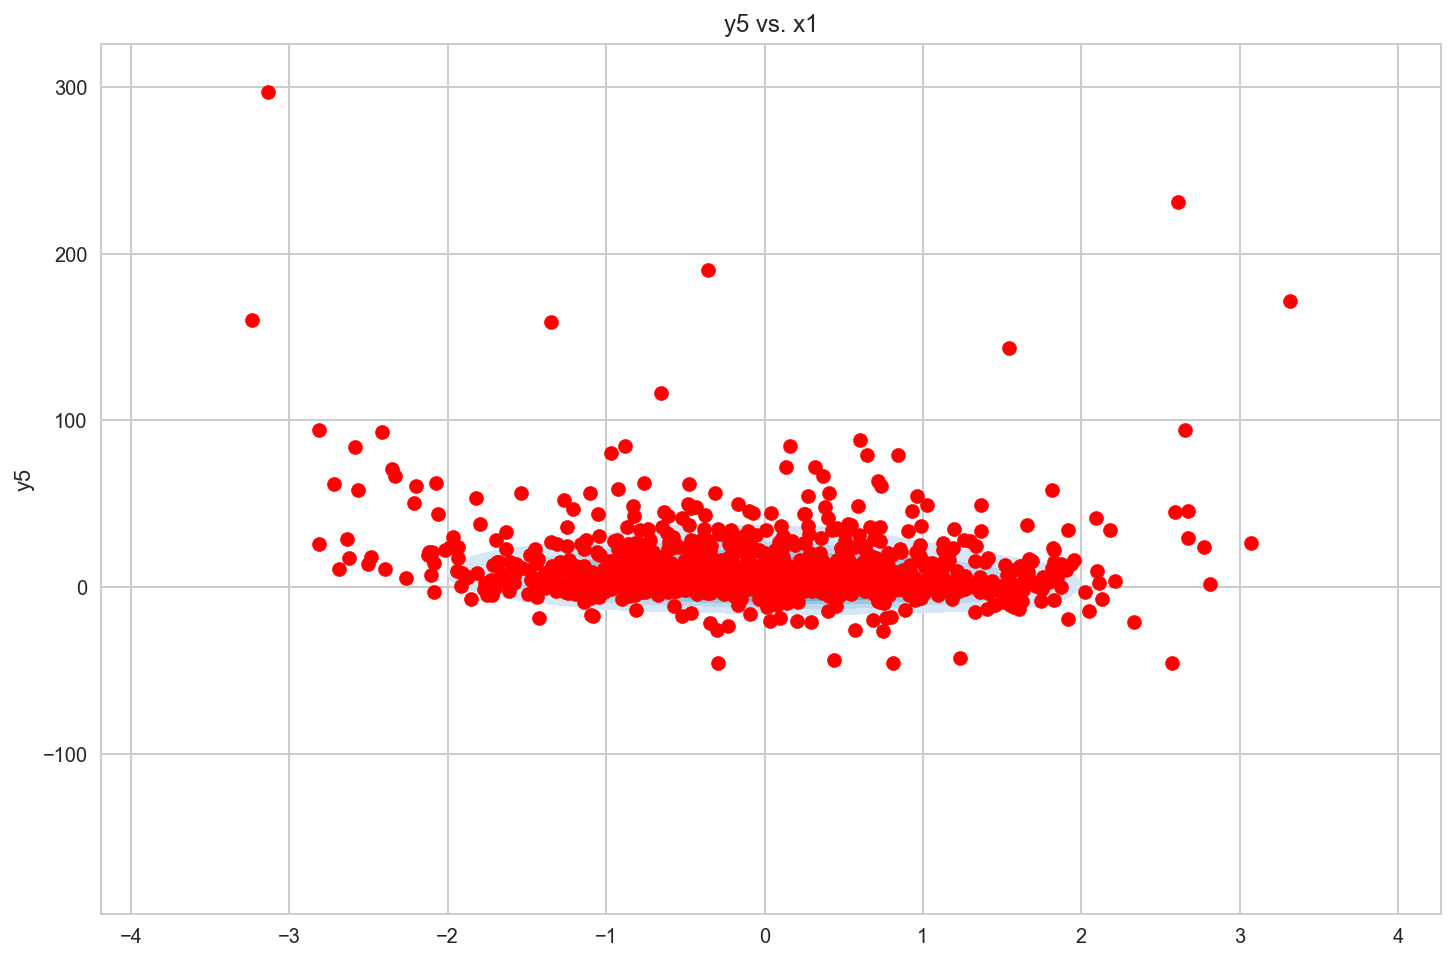

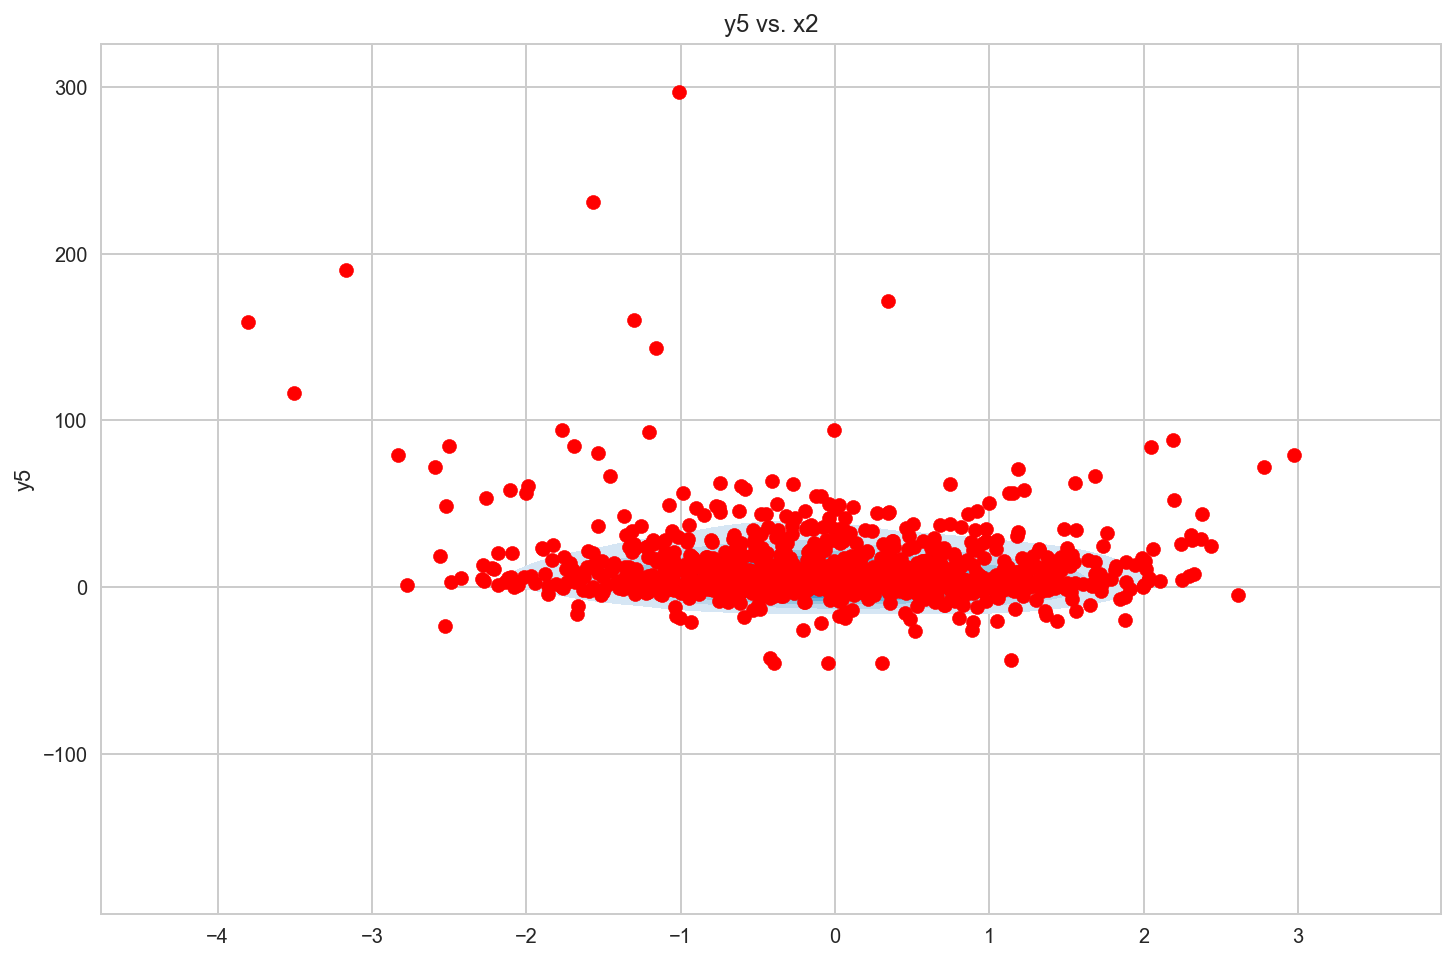

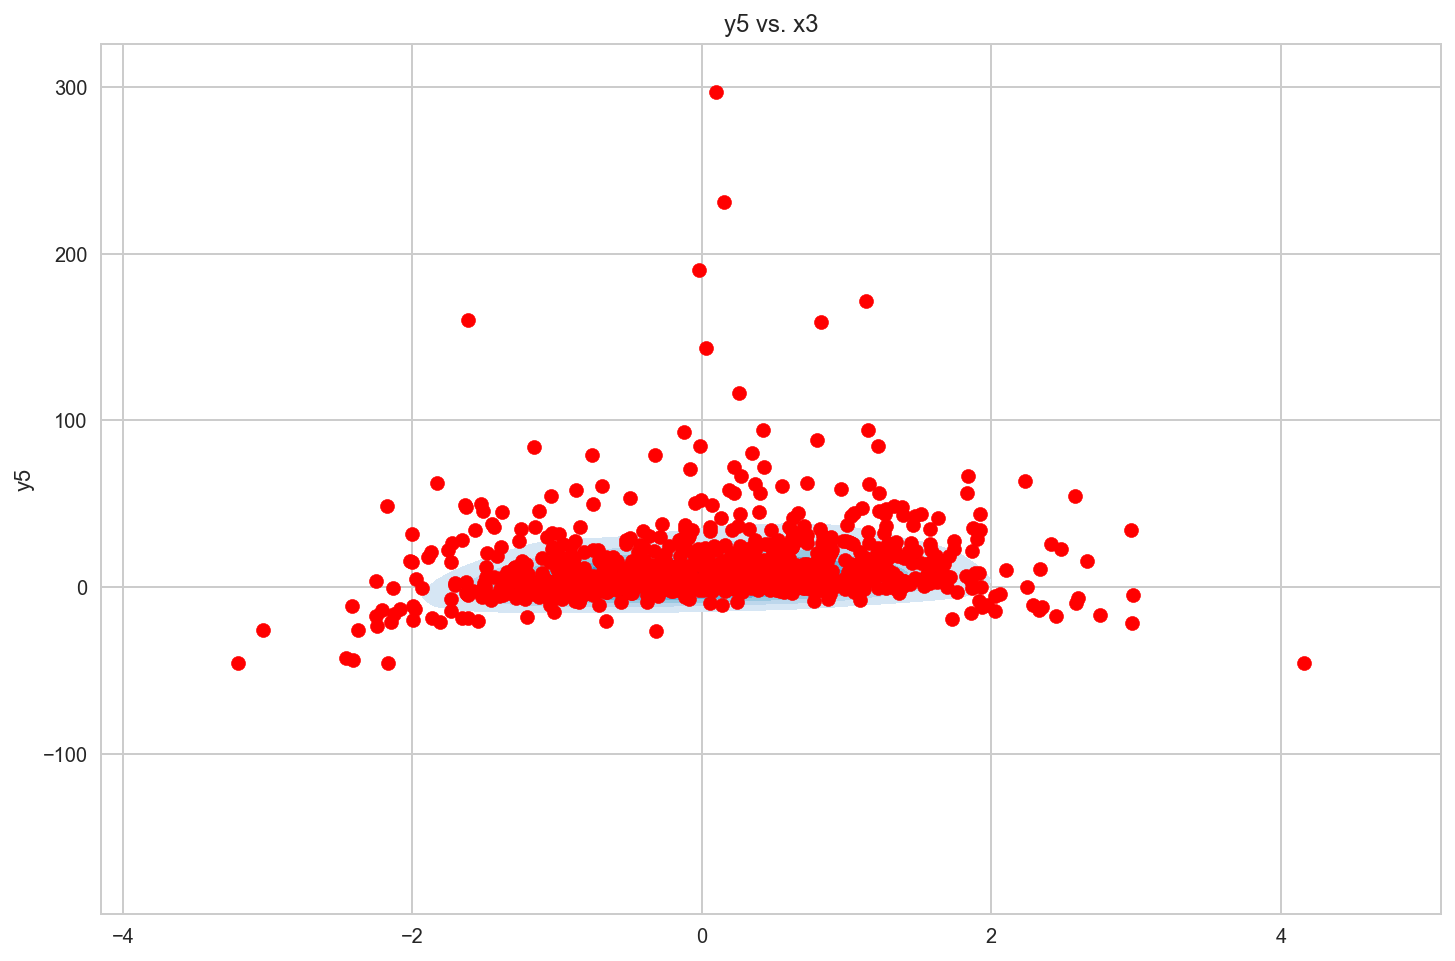

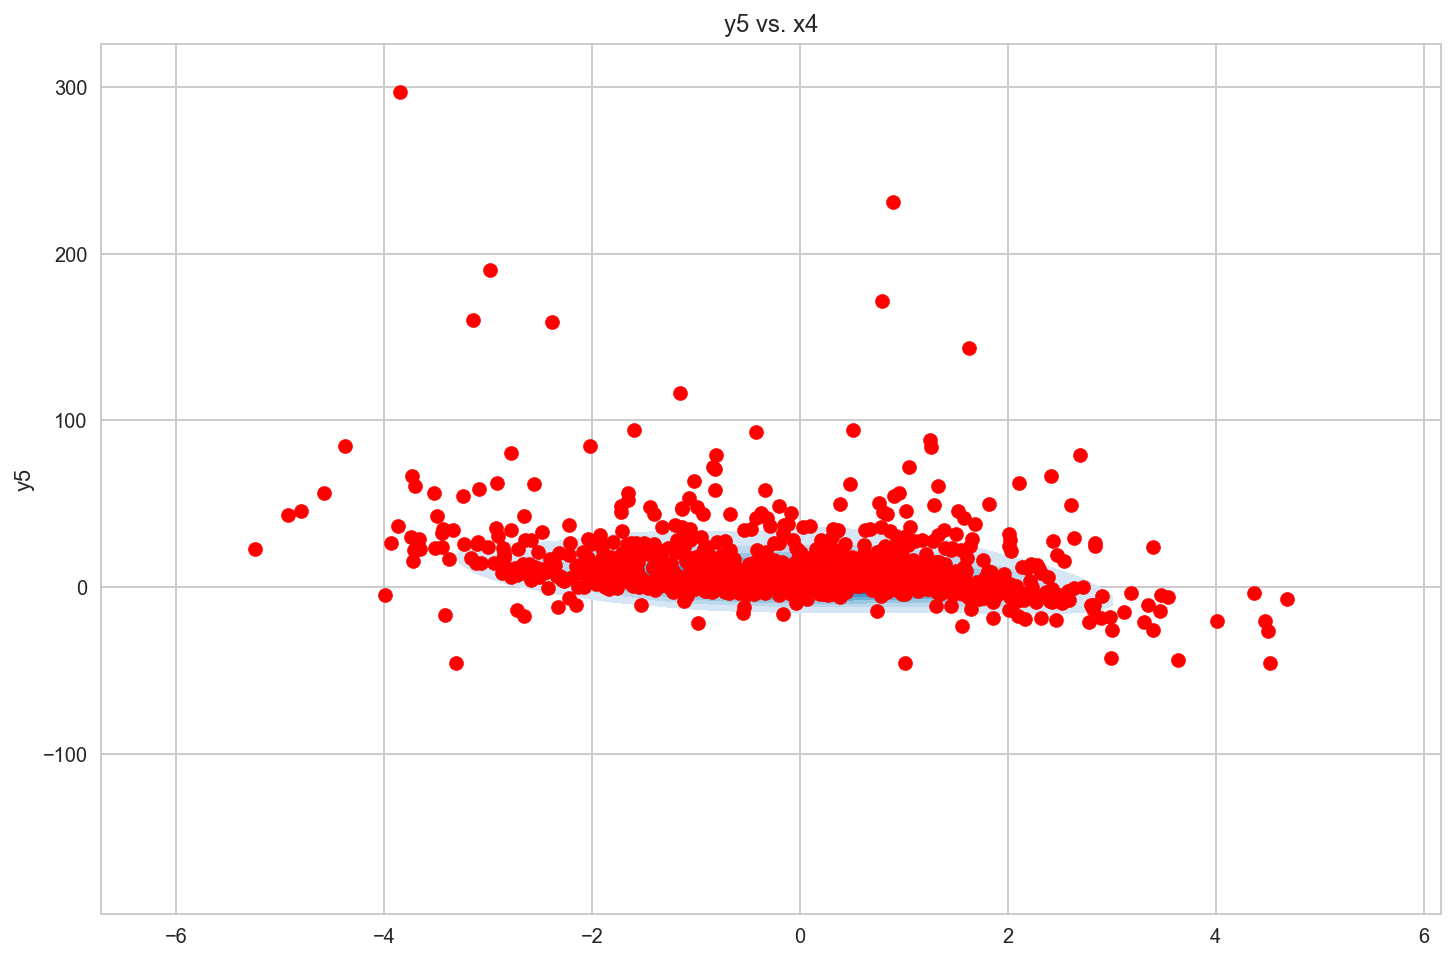

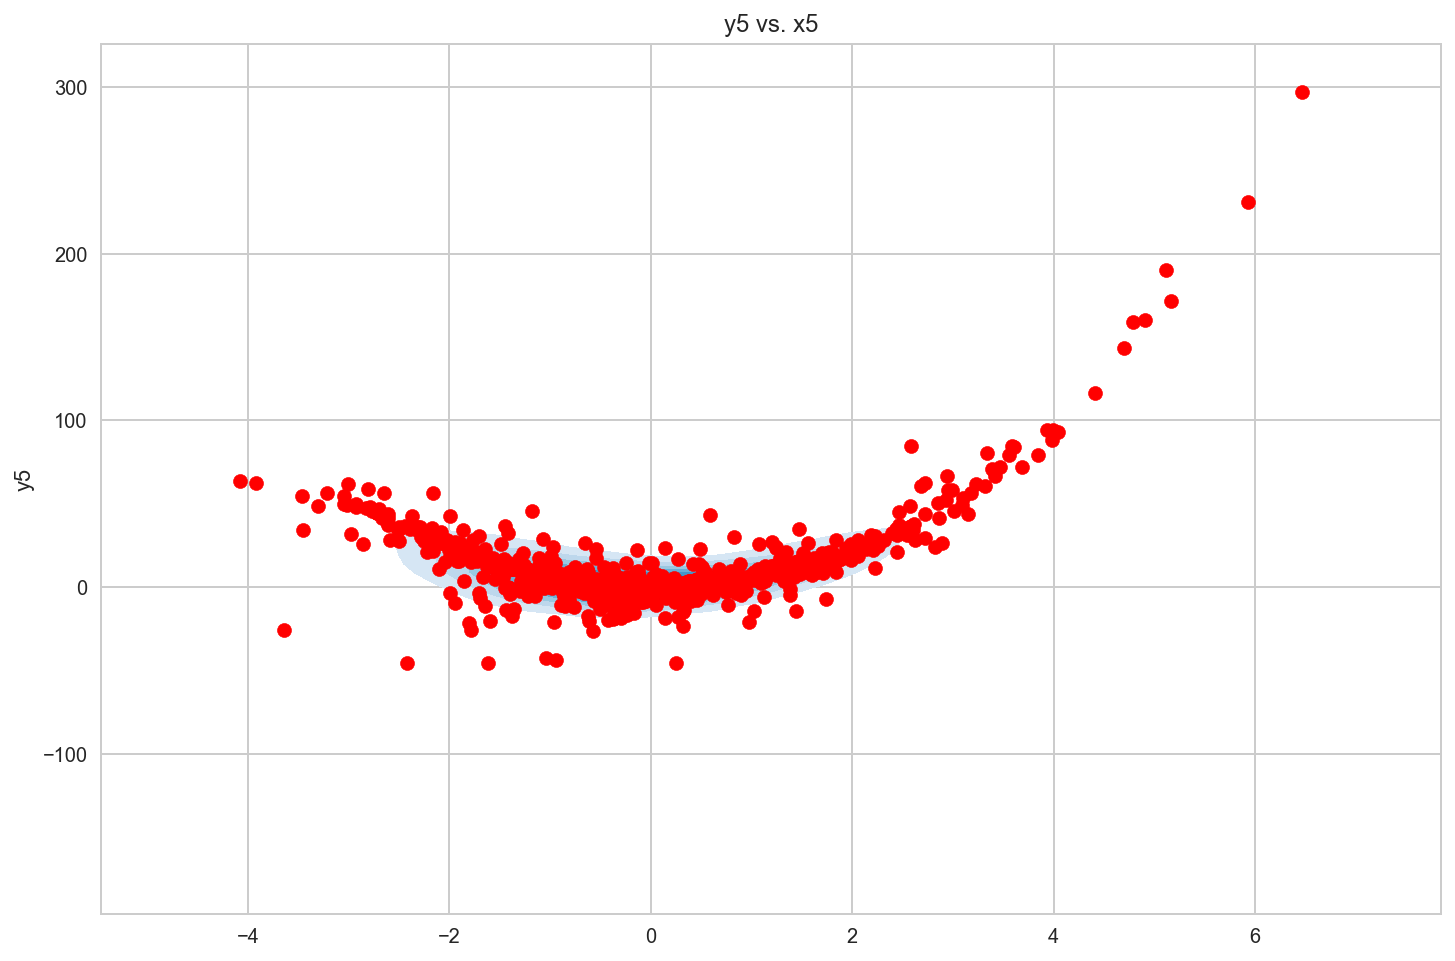

In [62]:
plt.title("y5 vs. x1")
sns.kdeplot(X_scaler.inverse_transform(X_val)[:, 0], y_val['y5'], cmap="Blues", shade=True, shade_lowest=False)
plt.scatter(X_scaler.inverse_transform(X_val)[:, 0], preds[:, 4], c='r')
plt.show()
plt.title("y5 vs. x2")
sns.kdeplot(X_scaler.inverse_transform(X_val)[:, 1], y_val['y5'], cmap="Blues", shade=True, shade_lowest=False)
plt.scatter(X_scaler.inverse_transform(X_val)[:, 1], preds[:, 4], c='r')
plt.show()
plt.title("y5 vs. x3")
sns.kdeplot(X_scaler.inverse_transform(X_val)[:, 2], y_val['y5'], cmap="Blues", shade=True, shade_lowest=False)
plt.scatter(X_scaler.inverse_transform(X_val)[:, 2], preds[:, 4], c='r')
plt.show()
plt.title("y5 vs. x4")
sns.kdeplot(X_scaler.inverse_transform(X_val)[:, 3], y_val['y5'], cmap="Blues", shade=True, shade_lowest=False)
plt.scatter(X_scaler.inverse_transform(X_val)[:, 3], preds[:, 4], c='r')
plt.show()
plt.title("y5 vs. x5")
sns.kdeplot(X_scaler.inverse_transform(X_val)[:, 4], y_val['y5'], cmap="Blues", shade=True, shade_lowest=False)
plt.scatter(X_scaler.inverse_transform(X_val)[:, 4], preds[:, 4], c='r')
plt.show()

### Partials of y5 with x5

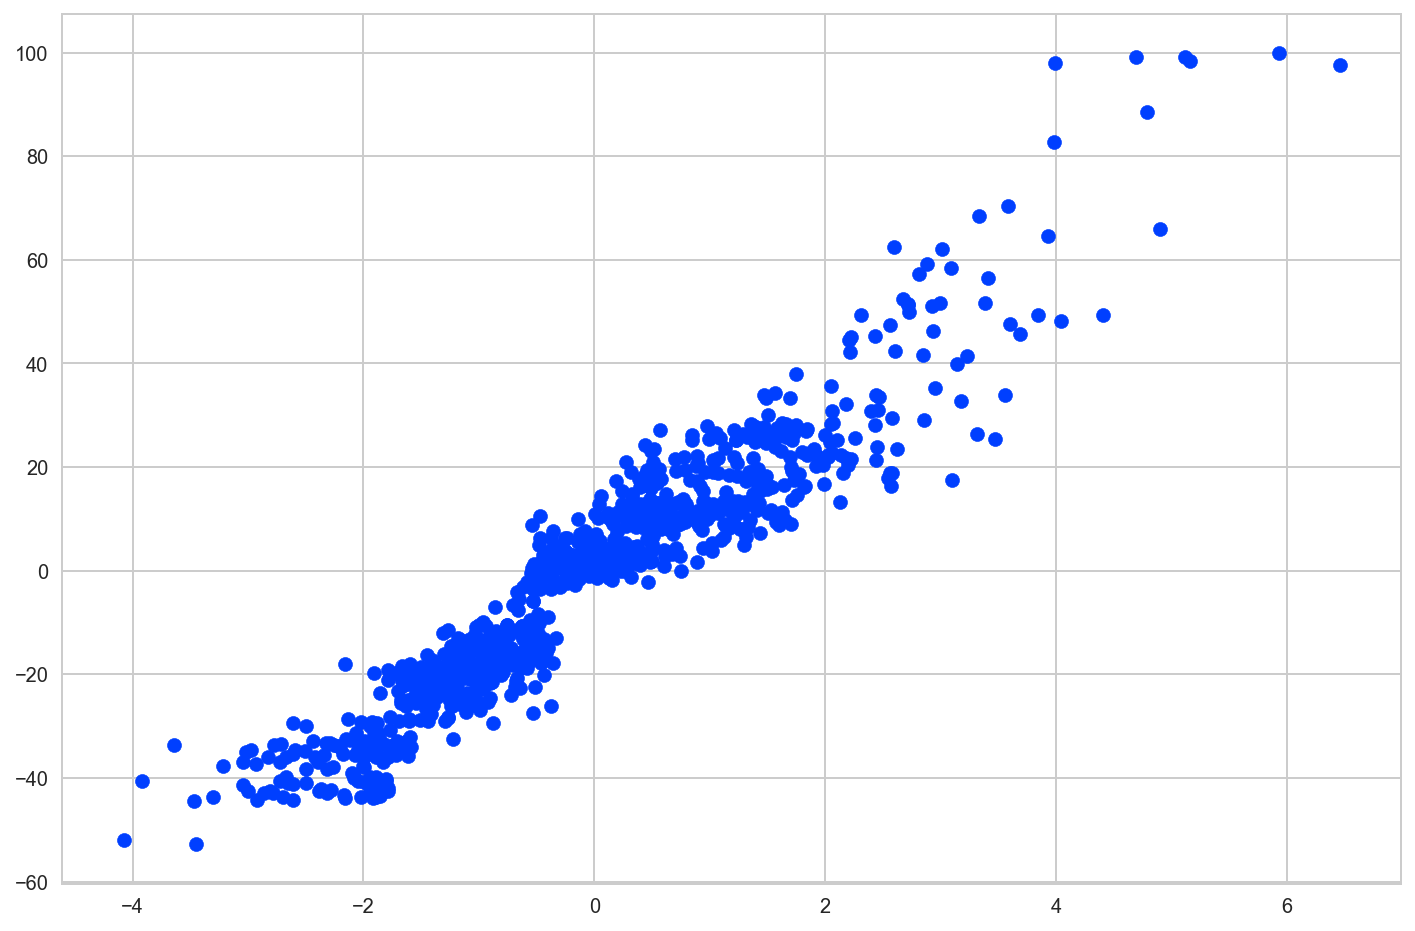

In [66]:
plt.scatter(X_scaler.inverse_transform(X_val)[:, 4], partials[0][:, 4])

### Partials of y4 with x4

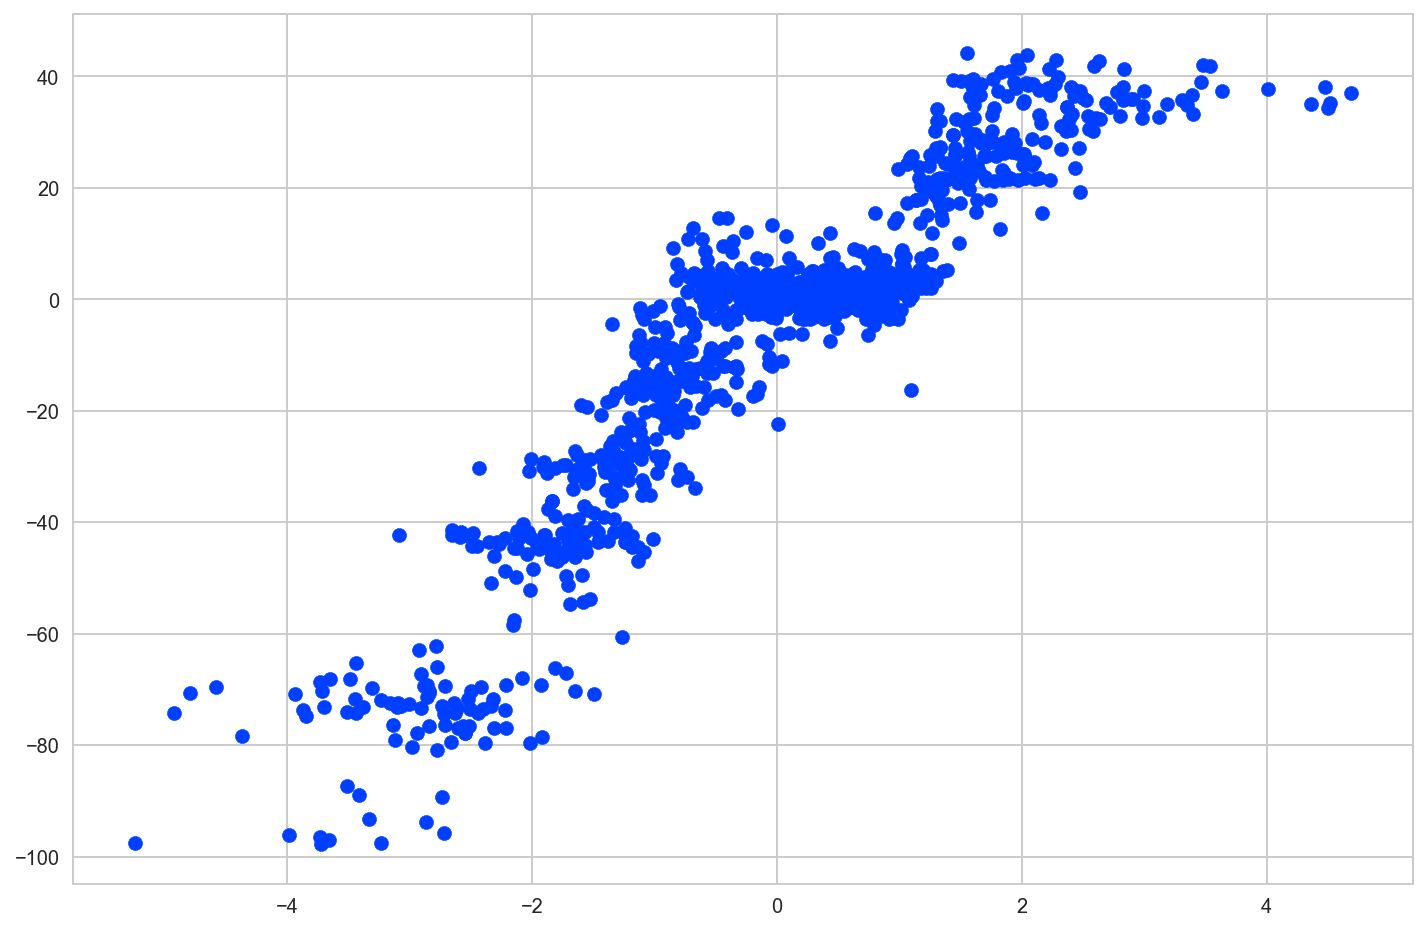

In [67]:
plt.scatter(X_scaler.inverse_transform(X_val)[:, 3], partials[0][:, 3])